In [1]:
import numpy as np
import xarray as xr
import re
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from functools import partial
import matplotlib as mpl
import pandas as pd
from importlib import reload
from dask.distributed import wait
import seaborn as sns

mkdir -p failed for path /scratch/v45/dr4292/tmp/.cache/matplotlib: [Errno 13] Permission denied: '/scratch/v45/dr4292/tmp/.cache'
Matplotlib created a temporary cache directory at /jobfs/136846996.gadi-pbs/matplotlib-tdseh49t because there was an issue with the default path (/scratch/v45/dr4292/tmp/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import os, sys

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import constants
import toe_constants as toe_const
import toe_calc as toe
import toe_data_analysis as toe_data_an
import toe_plots# as toe_plots
import plotting_utils
from plotting_utils import add_lat_markers
toe_calc = toe
import utils

logger = utils.get_notebook_logger()

In [7]:
# client.close()

In [3]:
from dask.distributed import Client, wait
# client.close()
client = Client(threads_per_worker=1, n_workers=50)
client

<Client: 'tcp://127.0.0.1:41607' processes=50 threads=50, memory=248.00 GiB>

<h1 style='color:yellow'> General Functions</h1>

<h2 style='color:cyan'> Opening Files </h2>

In [4]:
CHUNK_DICT = {
    'best_tas': {'time':-1, 'lat':180//3},
    'cesm1': {'member': -1, 'time':-1, 'lon':144//6, 'lat':72//12},
    'era5': {'time':-1, 'lon':1440//12, 'lat':-1},
    'access': {'time':-1, 'member':1, 'lat': -1, 'lon':-1}#144//3}

}

def get_chunks(name):
    if 'best' in name: return CHUNK_DICT['best_tas']
    elif 'cesm1' in name: return CHUNK_DICT['cesm1']
    elif 'access' in name: return CHUNK_DICT['access']
    return 'auto' 

In [5]:
def open_files_datatree(fname_dict, tree_name: str, chunks=None, **kwargs):
    """
    Opens multiple NetCDF files and organizes them into a DataTree.

    Parameters:
    - fname_dict (dict): Dictionary where keys are names and values are file paths.
    - tree_name (str): Name for the root of the DataTree.
    - **kwargs: Additional keyword arguments passed to `xr.open_dataset`.

    Returns:
    - xr.DataTree: A DataTree object containing the datasets.
    """
    data_tree_dict = {}
    for name, path in fname_dict.items():
        # if chunks == 'dataset': chunks = CHUNK_DICT.get('era5' if 'era5' in name else 'best')
        chunk = get_chunks(name) if chunks is None else chunks
        print(f'{name} - {chunk}')
        ds = xr.open_dataset(path, **kwargs).chunk(chunk)
        ds.attrs['name'] = name
        dt = xr.DataTree(ds, name=name)
        data_tree_dict[name] = dt
        

    tree = xr.DataTree(name=tree_name, children=data_tree_dict)
    return tree

In [6]:
class FileNameManager:
    def __init__(self, file_names: list, root_path: str):
        """
        Initialize the FileNameManager with a list of file names and a root path.

        Parameters:
        - file_names (list): List of file name strings.
        - root_path (str): The root directory path.
        """
        self.file_names = file_names
        self.root_path = root_path

    def generate_dict(self, fname: str) -> dict:
        """
        Generate a dictionary mapping a simplified name (from file_names) to full paths.

        Parameters:
        - fname (str): File name to be appended to each directory.

        Returns:
        - dict: Dictionary with simplified names as keys and full file paths as values.
        """
        return {
            f.split('(')[0].rstrip('_ ').strip(): os.path.join(self.root_path, f, fname)
            for f in self.file_names
        }

    def generate_dict_no_strip(self, fname: str) -> dict:
        """
        Generate a dictionary mapping a simplified name (from file_names) to full paths.

        Parameters:
        - fname (str): File name to be appended to each directory.

        Returns:
        - dict: Dictionary with simplified names as keys and full file paths as values.
        """
        return {
            f: os.path.join(self.root_path, f, fname)
            for f in self.file_names
        }
    def __repr__(self):
        return f'{self.root_path}' + f'\n----\n{self.file_names}'

In [7]:
# Get just the files that have the string 
all_files =  np.sort(os.listdir(constants.TOE_SAVE_DIR))
all_files

array(['.ipynb_checkpoints', 'access_ssp585_tas_(1880_1909)',
       'best_tas_(1880_1910)', 'best_tas_(1890_1920)',
       'best_tas_(1900_1930)', 'best_tas_(1910_1940)',
       'best_tas_(1920_1950)', 'best_tas_(1920_1950)_16p0x16p0',
       'best_tas_(1920_1950)_2p0x2p0', 'best_tas_(1920_1950)_32p0x32p0',
       'best_tas_(1920_1950)_4p0x4p0', 'best_tas_(1920_1950)_8p0x8p0',
       'best_tas_(1930_1960)', 'best_tas_(1940_1970)',
       'best_tas_multi_base_period.zarr',
       'cesm1_lens_rcp85_tas_(1920_1950)',
       'cesm1_lens_rcp85_tas_multi_base_period.zarr', 'era5', 'old',
       'to_delete'], dtype='<U43')

<h2 style='color:cyan'> ToE Calculation </h2>

In [8]:
def get_test_threshold(test: str, threshold_profile:toe_const.ThresholdProfileBase) -> float:
    """
    Get the threshold value for a given test based on the specified threshold profile.

    Parameters:
    ----------
    test : str
        The name of the test (e.g., a p-value test, overlap test, etc.).
    threshold_profile : toe_const.ThresholdProfileBase
        An instance of the threshold profile containing threshold values.

    Returns:
    -------
    float or None
        The threshold value associated with the test, or None if the test is unknown.
    """
    if test in toe_const.PVALUE_TESTS: return threshold_profile.pvalue_threshold
    elif test in toe_const.OVERLAP_TESTS: return threshold_profile.overlap_threshold
    elif 'hd' in test: return threshold_profile.hd_threshold
    elif 'sn' in test: return threshold_profile.sn_threshold
    else: return None

In [9]:
# for test in list(toe_metric_tree[list(toe_metric_tree)[0]]): 
#     threshold = get_test_threshold(test, toe_const.ThresholdProfileUnusual)
#     print(test, threshold)

In [10]:
get_test_threshold('sn', toe_const.ThresholdProfileUnusual)

1

In [11]:
def get_permanent_exceedance_multi_metrics(toe_metrics_ds: xr.Dataset,
                                           threshold_profile:toe_const.ThresholdProfileBase,
                                           logginglevel='ERROR'):
    """
    Determine the year of permanent exceedance for multiple tests in the dataset.

    Parameters:
    ----------
    toe_metrics_ds : xarray.Dataset
        An xarray Dataset containing time series metrics for multiple tests.
    threshold_profile : toe_const.ThresholdProfileBase
        An instance of the threshold profile containing threshold values.

    Returns:
    -------
    xarray.Dataset
        A merged dataset containing the year of permanent exceedance for all tests.
    """
    utils.change_logginglevel(logginglevel)

    logger.debug(toe_metrics_ds)
        
    exceedance_list = []

    for test in toe_metrics_ds:
        # Retrieve the threshold dynamically
        threshold = get_test_threshold(test, threshold_profile)

        # Determine the comparison function
        comp_func = np.greater_equal if (('sn' in test) or ('hd' in test)) else np.less
        logger.info(f'{test=} - {threshold=} - {comp_func}')

        # Apply absolute value for 'sn'-related tests
        data = np.abs(toe_metrics_ds[test]) if 'sn' in test else toe_metrics_ds[test]

        # Calculate permanent exceedance
        exceedance_da = toe.get_permanent_exceedance(
            data, threshold=threshold, comparison_func=comp_func)
        exceedance_list.append(exceedance_da)

    toe_ds = xr.merge(exceedance_list)
    return toe_ds

In [12]:
def check_for_null(ds): return not ds.dims and not ds.data_vars
def get_non_emergence(toe_ds): return xr.where(np.isnan(toe_ds), 1, 0)

tree_subset_vars = lambda ds: None if check_for_null(ds) else ds[vars_with_multi_thresh]

In [13]:
def sign_final_time(toe_metrics_ds): 
    if check_for_null(toe_metrics_ds): return
    da = xr.where(toe_metrics_ds.sn_lowess_full.isel(time=-1) > 0, 1, -1)
    da.name = 'sign'
    ds = da.to_dataset()
    return ds

<h1 style='color:yellow'> ToE Main </h1>

<h2 style='color:cyan'> Opening Data </h2>

In [14]:
# PICONTROL_PATH = '/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/v20190320'

In [15]:
PICONTROL_PATH = '/g/data/w40/ab2313/time_of_emergence/cesm1_picontrol.zarr'

In [16]:
# le_pi_ds = xr.open_mfdataset(os.path.join(PICONTROL_PATH, '*.nc')).persist()
# le_pi_ds = le_pi_ds['tas'].resample(time='YE').mean().persist()#.squeeze()
# le_pi_ds = le_pi_ds.chunk({'time':-1, 'lat':192//2, 'lon':288//12})
# le_pi_ds.to_zarr('/g/data/w40/ab2313/time_of_emergence/cesm1_picontrol.zarr', mode='w')
# wait(le_pi_ds);

In [17]:
le_pi_ds = xr.open_dataset(PICONTROL_PATH, engine='zarr')['tas'].chunk('auto').persist()#.compute()
wait(le_pi_ds);

In [18]:
le_pi_ds

<xarray.DataArray 'tas' (time: 1200, lat: 192, lon: 288)> Size: 265MB
dask.array<xarray-<this-array>, shape=(1200, 192, 288), dtype=float32, chunksize=(606, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 10kB 0001-12-31 00:00:00 ... 1200-12-31 00:00:00
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas

In [19]:
# files = [
#     'best_tas_(1920_1950)',
#     'access_ssp585_tas_(1920_1950)'
# ]

files = [
    'best_tas_(1880_1910)',
    'access_ssp585_tas_(1880_1909)'
]

In [20]:
os.listdir(os.path.join(constants.TOE_SAVE_DIR, files[1]))

['data.zarr', 'toe_metrics.zarr', 'data_availability_mask.zarr', 'signal.zarr']

In [21]:
# files = [f for f in files if 'access_ssp585_r10i1p1f1_pr_QSJUN_(1959_1989' not in f]
# files

In [22]:
base_file_manager = FileNameManager(files, constants.TOE_SAVE_DIR) #+ '/error')
base_file_manager

/g/data/w40/ab2313/time_of_emergence/toe_metrics
----
['best_tas_(1880_1910)', 'access_ssp585_tas_(1880_1909)']

In [23]:
fname_metric_dict = base_file_manager.generate_dict('toe_metrics.zarr')
fname_signal_dict = base_file_manager.generate_dict('signal.zarr')
fname_data_dict = base_file_manager.generate_dict('data.zarr')
data_availability_mask_dict = base_file_manager.generate_dict('data_availability_mask.zarr')

fname_data_dict

{'best_tas': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/best_tas_(1880_1910)/data.zarr',
 'access_ssp585_tas': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_tas_(1880_1909)/data.zarr'}

In [24]:
%%time
toe_metric_tree = open_files_datatree(
    fname_metric_dict, 'metrics', engine='zarr', use_cftime=True).persist()
wait(toe_metric_tree)

best_tas - {'time': -1, 'lat': 60}
access_ssp585_tas - {'time': -1, 'member': 1, 'lat': -1, 'lon': -1}
CPU times: user 168 ms, sys: 36.6 ms, total: 205 ms
Wall time: 193 ms


DoneAndNotDoneFutures(done=set(), not_done=set())

In [25]:
list(toe_metric_tree)

['best_tas', 'access_ssp585_tas']

In [26]:
data_tree = open_files_datatree(
    fname_data_dict, 'data', engine='zarr', use_cftime=True).persist()
wait(data_tree)

best_tas - {'time': -1, 'lat': 60}
access_ssp585_tas - {'time': -1, 'member': 1, 'lat': -1, 'lon': -1}


DoneAndNotDoneFutures(done=set(), not_done=set())

In [27]:
signal_tree = open_files_datatree(
    fname_signal_dict, 'signal', engine='zarr', use_cftime=True).persist()
wait(signal_tree)

best_tas - {'time': -1, 'lat': 60}
access_ssp585_tas - {'time': -1, 'member': 1, 'lat': -1, 'lon': -1}


DoneAndNotDoneFutures(done=set(), not_done=set())

In [28]:
data_availability_tree = open_files_datatree(
    data_availability_mask_dict, 'data_availability_mask', engine='zarr', chunks='auto').compute()
wait(data_availability_tree)

best_tas - auto
access_ssp585_tas - auto


DoneAndNotDoneFutures(done=set(), not_done=set())

In [29]:
data_availability_mask_dict

{'best_tas': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/best_tas_(1880_1910)/data_availability_mask.zarr',
 'access_ssp585_tas': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_tas_(1880_1909)/data_availability_mask.zarr'}

In [30]:
lsm_dict = {
    'best_tas': '/g/data/w40/ab2313/time_of_emergence/best/best_mask.zarr',
    'access_ssp585_tas': '/g/data/w40/ab2313/time_of_emergence/access_lsm.zarr'
    # 'access_ssp585_tas': '/g/data/w40/ab2313/time_of_emergence/cesm1_mask.zarr'
}

In [31]:
lsm_tree = open_files_datatree(
    lsm_dict, 'lsm', engine='zarr', chunks='auto').persist()
wait(lsm_tree)

best_tas - auto
access_ssp585_tas - auto


DoneAndNotDoneFutures(done=set(), not_done=set())

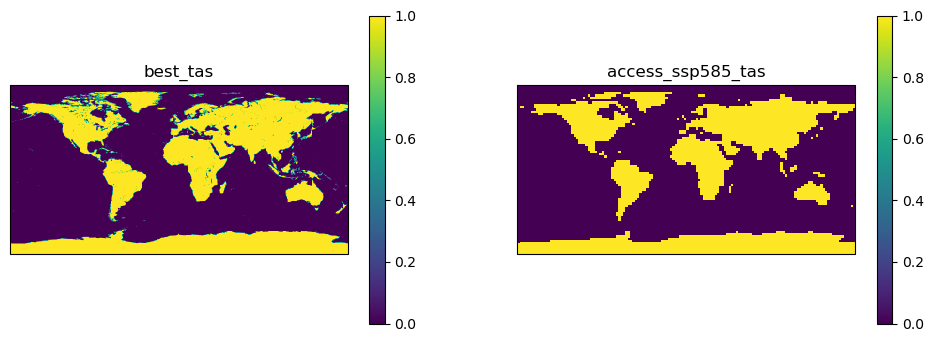

In [32]:
fig = plt.figure(figsize=(12, 4))
axes = [fig.add_subplot(1, 2, i, projection=ccrs.PlateCarree()) for i in range(1, 3)]

for num,variable in enumerate(lsm_tree):
    lsm_tree[variable].to_dataset().to_array().plot(ax=axes[num])
    axes[num].set_title(variable)

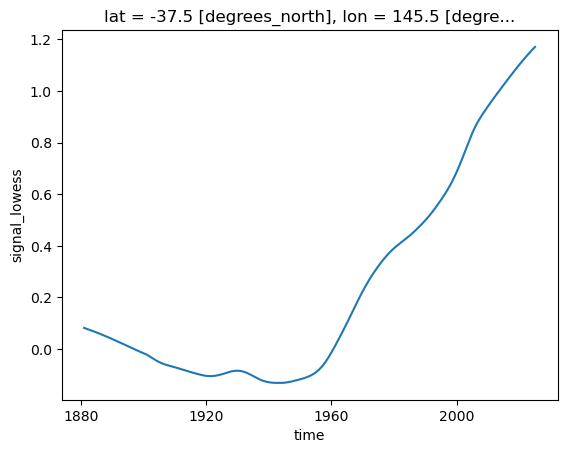

In [33]:
signal_tree.best_tas['signal_lowess'].sel(lat=-38, lon=145, method='nearest').plot()

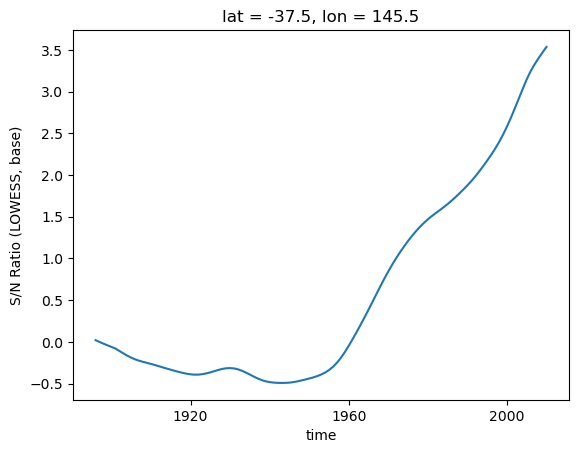

In [34]:
toe_metric_tree.best_tas['sn_lowess_base'].sel(lat=-38, lon=145, method='nearest').plot()

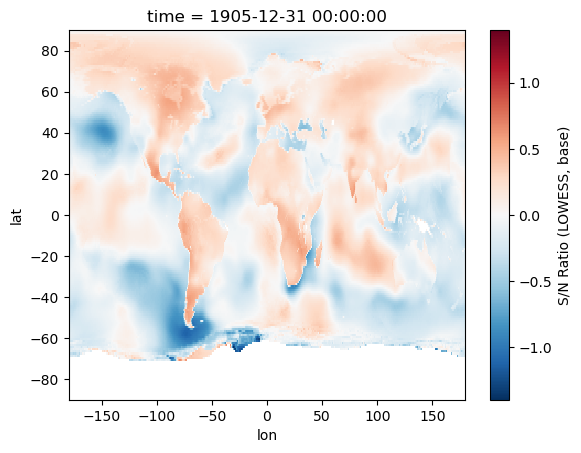

In [35]:
toe_metric_tree.best_tas.to_dataset()['sn_lowess_base'].isel(time=10).plot()

<h2 style='color:cyan'> Calculations </h2>

<h3 style='color:green'> Maps </h3>

In [36]:
toe_tree = toe_metric_tree.map_over_datasets(
    get_permanent_exceedance_multi_metrics, toe_const.ThresholdProfileUnusual, 'INFO').compute()

 - test='frac' - threshold=62 - <ufunc 'less'>
 - test='hd' - threshold=33 - <ufunc 'greater_equal'>
 - test='ks' - threshold=0.01 - <ufunc 'less'>
 - test='perkins' - threshold=62 - <ufunc 'less'>
 - test='sn_hawkins_base' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_hawkins_full' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_lowess_base' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_lowess_full' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_mean' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_mean_roll' - threshold=1 - <ufunc 'greater_equal'>
 - test='ttest' - threshold=0.01 - <ufunc 'less'>
 - test='frac' - threshold=62 - <ufunc 'less'>
 - test='hd' - threshold=33 - <ufunc 'greater_equal'>
 - test='ks' - threshold=0.01 - <ufunc 'less'>
 - test='perkins' - threshold=62 - <ufunc 'less'>
 - test='sn_lowess_base' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_lowess_full' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_mean' - threshold=1 - <ufunc 

In [37]:
sign_tf_tree = toe_metric_tree.map_over_datasets(sign_final_time).compute()

In [38]:
vars_with_multi_thresh =[
    'frac', 'hd', 'perkins',
    'sn_lowess_base', 'sn_lowess_full',
    'sn_mean', 'sn_mean_roll'
]

In [39]:
toe_subset_metric_tree = toe_metric_tree.map_over_datasets(tree_subset_vars).compute()

In [40]:
toe_unfamiliar = toe_subset_metric_tree.map_over_datasets(
    get_permanent_exceedance_multi_metrics, toe_const.ThresholdProfileUnfamiliar, 'INFO').compute()

 - test='frac' - threshold=32 - <ufunc 'less'>
 - test='hd' - threshold=66 - <ufunc 'greater_equal'>
 - test='perkins' - threshold=32 - <ufunc 'less'>
 - test='sn_lowess_base' - threshold=2 - <ufunc 'greater_equal'>
 - test='sn_lowess_full' - threshold=2 - <ufunc 'greater_equal'>
 - test='sn_mean' - threshold=2 - <ufunc 'greater_equal'>
 - test='sn_mean_roll' - threshold=2 - <ufunc 'greater_equal'>
 - test='frac' - threshold=32 - <ufunc 'less'>
 - test='hd' - threshold=66 - <ufunc 'greater_equal'>
 - test='perkins' - threshold=32 - <ufunc 'less'>
 - test='sn_lowess_base' - threshold=2 - <ufunc 'greater_equal'>
 - test='sn_lowess_full' - threshold=2 - <ufunc 'greater_equal'>
 - test='sn_mean' - threshold=2 - <ufunc 'greater_equal'>
 - test='sn_mean_roll' - threshold=2 - <ufunc 'greater_equal'>


In [41]:
toe_unknown = toe_subset_metric_tree.map_over_datasets(
    get_permanent_exceedance_multi_metrics, toe_const.ThresholdProfileUnknown, 'INFO').compute()

 - test='frac' - threshold=13 - <ufunc 'less'>
 - test='hd' - threshold=82 - <ufunc 'greater_equal'>
 - test='perkins' - threshold=13 - <ufunc 'less'>
 - test='sn_lowess_base' - threshold=3 - <ufunc 'greater_equal'>
 - test='sn_lowess_full' - threshold=3 - <ufunc 'greater_equal'>
 - test='sn_mean' - threshold=3 - <ufunc 'greater_equal'>
 - test='sn_mean_roll' - threshold=3 - <ufunc 'greater_equal'>
 - test='frac' - threshold=13 - <ufunc 'less'>
 - test='hd' - threshold=82 - <ufunc 'greater_equal'>
 - test='perkins' - threshold=13 - <ufunc 'less'>
 - test='sn_lowess_base' - threshold=3 - <ufunc 'greater_equal'>
 - test='sn_lowess_full' - threshold=3 - <ufunc 'greater_equal'>
 - test='sn_mean' - threshold=3 - <ufunc 'greater_equal'>
 - test='sn_mean_roll' - threshold=3 - <ufunc 'greater_equal'>


In [42]:
# THe regions that do not everge (this is where there is no emergence at the final time step)
does_not_emerge_tree = toe_tree.map_over_datasets(get_non_emergence).compute()
does_not_emerge_unfamiliar_tree = toe_unfamiliar.map_over_datasets(get_non_emergence).compute()
does_not_emerge_unknown_tree = toe_unknown.map_over_datasets(get_non_emergence).compute()

In [43]:
toe_frac_zero_tree = xr.DataTree.from_dict({
    b: toe.get_permanent_exceedance(toe_metric_tree[b].frac, 0.1, np.less_equal).compute().to_dataset()
    for b in toe_metric_tree
})

In [44]:
toe_frac_50_tree = xr.DataTree.from_dict({
    b: toe.get_permanent_exceedance(toe_metric_tree[b].frac, 50, np.less_equal).compute().to_dataset()
    for b in toe_metric_tree
})

In [45]:
# toe_best_base_period_ds['sn_lowess_base'].plot(col='base_period', col_wrap=3)

<h3 style='color:green'> Time Series </h3>

In [46]:
def percent_emerged(toe_metric_ds, toe_ds, does_not_emerge_ds, return_all=False):
    # Check for null input
    if check_for_null(toe_metric_ds): return

    # print(toe_metric_ds, toe_ds, sep='\n---\n')

    # Ensure proper handling of xarray objects
    if not isinstance(toe_metric_ds, (xr.Dataset, xr.DataArray)):
        raise TypeError(f"Expected xarray.Dataset or xarray.DataArray, got {type(toe_metric_ds)}")
    
    # Ensure time dimension is valid
    if 'time' not in toe_metric_ds.dims or not hasattr(toe_metric_ds.time, 'dt'):
        raise ValueError("The 'time' dimension is missing or not a datetime array in toe_metric_ds.")

    # Apply binary emergence calculation
    binary_emergence_ds = xr.apply_ufunc(
        toe_data_an.calculate_returned_binary_ds,
        toe_metric_ds,
        toe_ds,
        toe_metric_ds.time.dt.year.values,
        input_core_dims=[['time'], [], ['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized'
    )
    
    # Convert values to binary (1 or 0)
    binary_emergence_ds = xr.where(binary_emergence_ds == 1, 1, 0)
    # Only return where the dataset does emerge (seems to be issue for some reason)
    binary_emergence_ds = binary_emergence_ds.where(does_not_emerge_ds == 0)
    
    # Compute weights and percentage emergence
    only_1s_ds = xr.ones_like(binary_emergence_ds.isel(time=0))
    weights = toe_data_an.compute_weights(binary_emergence_ds)
    
    emergence_time_series_ds = toe_data_an.percentage_lat_lons(
        binary_emergence_ds, only_1s_ds, weights
    )

    if return_all: return emergence_time_series_ds, binary_emergence_ds, only_1s_ds
    
    return emergence_time_series_ds

In [47]:
ets_ds, be_ds, oo_ds = percent_emerged(
    toe_metric_tree.best_tas.to_dataset(),
    toe_tree.best_tas.to_dataset(),
    does_not_emerge_tree.best_tas.to_dataset(),
    return_all=True)

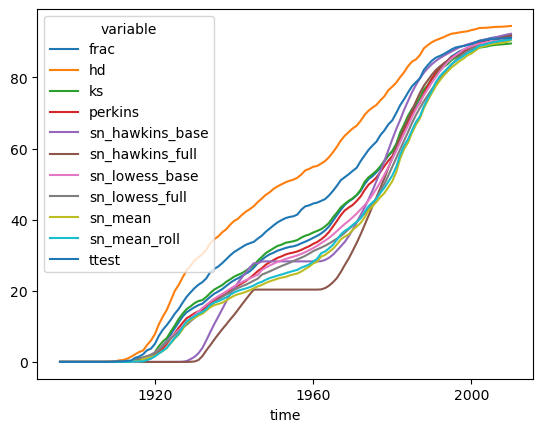

In [48]:
ets_ds.to_array().plot(hue='variable');

In [49]:
def percent_emerged_regions_over_tree(
    toe_metric_tree: xr.DataTree,
    toe_tree: xr.DataTree,
    does_not_emerge_tree: xr.DataTree,
    lsm_tree: xr.DataTree,
    logginglevel='ERROR'
) -> xr.DataTree:
    """
    Compute the percentage of emerged regions for each branch in the input trees.

    For each branch in `toe_metric_tree`, this function:
      - Converts corresponding branches in all input trees to xarray Datasets.
      - Calls `toe_data_an.percent_emerged_regions` to compute the percentage of emerged regions.
      - Stores the results in a dictionary and converts it into an xarray DataTree.

    Parameters:
        toe_metric_tree (xr.DataTree): Tree of metric data.
        toe_tree (xr.DataTree): Tree of toe data.
        does_not_emerge_tree (xr.DataTree): Tree of regions that do not emerge.
        lsm_tree (xr.DataTree): Tree of land surface mask data.

    Returns:
        xr.DataTree: A computed DataTree with time series of emerged region percentages.
    """
    utils.change_logginglevel(logginglevel)
    percent_time_dict = {}
    for branch in list(toe_metric_tree):
        logger.info(branch)
        percent_time_dict[branch] = toe_data_an.percent_emerged_regions(
            toe_metric_tree[branch].to_dataset(),
            toe_tree[branch].to_dataset(),
            does_not_emerge_tree[branch].to_dataset(),
            lsm_tree[branch].to_dataset().to_array().squeeze('variable'),
            logginglevel='INFO'
        )
    
    emergence_time_series_tree = xr.DataTree.from_dict(percent_time_dict)
    return emergence_time_series_tree.compute()

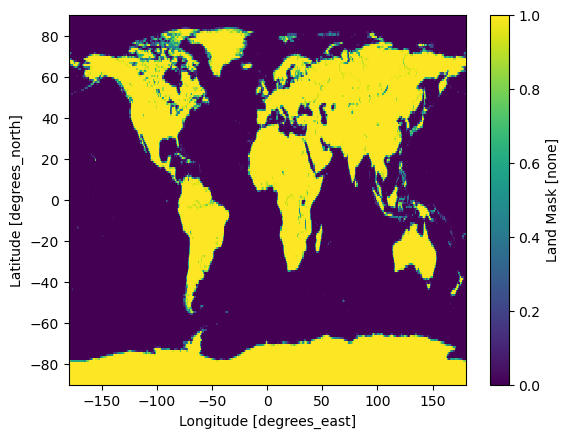

In [50]:
lsm_tree.best_tas.land_mask.plot()

In [51]:
emergence_time_series_tree = percent_emerged_regions_over_tree(
    toe_metric_tree,
    toe_tree,
    does_not_emerge_tree,
    lsm_tree
)

 - regionLatLonTuples.GLOBAL
 - regionLatLonTuples.LAND
 - regionLatLonTuples.OCEAN
 - regionLatLonTuples.NH
 - regionLatLonTuples.SH
 - regionLatLonTuples.TROPICS
 - regionLatLonTuples.MID_LAT_SH
 - regionLatLonTuples.MID_LAT_NH
 - regionLatLonTuples.ARCTIC
 - regionLatLonTuples.ANTARCTIC
 - ['global' 'land' 'ocean' 'nh' 'sh' 'tropics' 'mid_lat_sh' 'mid_lat_nh'
 'arctic' 'antarctic']
 - access_ssp585_tas
 - regionLatLonTuples.GLOBAL
 - regionLatLonTuples.LAND
 - regionLatLonTuples.OCEAN
 - regionLatLonTuples.NH
 - regionLatLonTuples.SH
 - regionLatLonTuples.TROPICS
 - regionLatLonTuples.MID_LAT_SH
 - regionLatLonTuples.MID_LAT_NH
 - regionLatLonTuples.ARCTIC
 - regionLatLonTuples.ANTARCTIC
 - ['global' 'land' 'ocean' 'nh' 'sh' 'tropics' 'mid_lat_sh' 'mid_lat_nh'
 'arctic' 'antarctic']


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 49.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [52]:
emergence_time_series_unknown_tree = percent_emerged_regions_over_tree(
    toe_subset_metric_tree,
    toe_unknown,
    does_not_emerge_unknown_tree,
    lsm_tree)

 - regionLatLonTuples.GLOBAL
 - regionLatLonTuples.LAND
 - regionLatLonTuples.OCEAN
 - regionLatLonTuples.NH
 - regionLatLonTuples.SH
 - regionLatLonTuples.TROPICS
 - regionLatLonTuples.MID_LAT_SH
 - regionLatLonTuples.MID_LAT_NH
 - regionLatLonTuples.ARCTIC
 - regionLatLonTuples.ANTARCTIC
 - ['global' 'land' 'ocean' 'nh' 'sh' 'tropics' 'mid_lat_sh' 'mid_lat_nh'
 'arctic' 'antarctic']
 - access_ssp585_tas
 - regionLatLonTuples.GLOBAL
 - regionLatLonTuples.LAND
 - regionLatLonTuples.OCEAN
 - regionLatLonTuples.NH
 - regionLatLonTuples.SH
 - regionLatLonTuples.TROPICS
 - regionLatLonTuples.MID_LAT_SH
 - regionLatLonTuples.MID_LAT_NH
 - regionLatLonTuples.ARCTIC
 - regionLatLonTuples.ANTARCTIC
 - ['global' 'land' 'ocean' 'nh' 'sh' 'tropics' 'mid_lat_sh' 'mid_lat_nh'
 'arctic' 'antarctic']


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 4.53 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [53]:
emergence_time_series_unfamiliar_tree = percent_emerged_regions_over_tree(
    toe_subset_metric_tree,
    toe_unfamiliar,
    does_not_emerge_unfamiliar_tree,
    lsm_tree
)

 - regionLatLonTuples.GLOBAL
 - regionLatLonTuples.LAND
 - regionLatLonTuples.OCEAN
 - regionLatLonTuples.NH
 - regionLatLonTuples.SH
 - regionLatLonTuples.TROPICS
 - regionLatLonTuples.MID_LAT_SH
 - regionLatLonTuples.MID_LAT_NH
 - regionLatLonTuples.ARCTIC
 - regionLatLonTuples.ANTARCTIC
 - ['global' 'land' 'ocean' 'nh' 'sh' 'tropics' 'mid_lat_sh' 'mid_lat_nh'
 'arctic' 'antarctic']
 - access_ssp585_tas
 - regionLatLonTuples.GLOBAL
 - regionLatLonTuples.LAND
 - regionLatLonTuples.OCEAN
 - regionLatLonTuples.NH
 - regionLatLonTuples.SH
 - regionLatLonTuples.TROPICS
 - regionLatLonTuples.MID_LAT_SH
 - regionLatLonTuples.MID_LAT_NH
 - regionLatLonTuples.ARCTIC
 - regionLatLonTuples.ANTARCTIC
 - ['global' 'land' 'ocean' 'nh' 'sh' 'tropics' 'mid_lat_sh' 'mid_lat_nh'
 'arctic' 'antarctic']


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 4.53 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


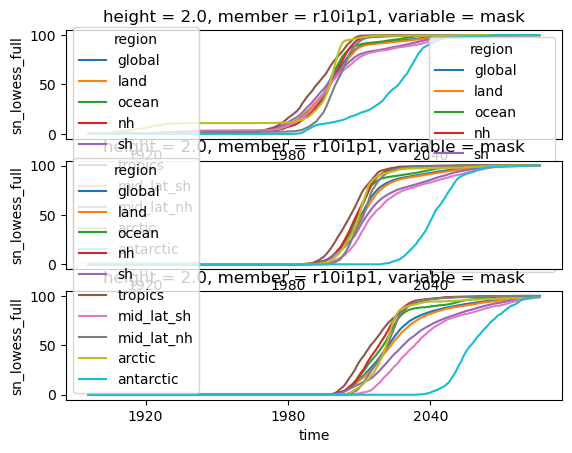

In [54]:
fig, axes = plt.subplots(3, 1)

emergence_time_series_tree['access_ssp585_tas']['sn_lowess_full'].isel(member=0).plot(ax=axes[0], hue='region');
emergence_time_series_unfamiliar_tree['access_ssp585_tas']['sn_lowess_full'].isel(member=0).plot(ax=axes[1], hue='region');
emergence_time_series_unknown_tree['access_ssp585_tas']['sn_lowess_full'].isel(member=0).plot(ax=axes[2], hue='region');

In [55]:
# percent_time_dict = {}
# for branch in list(toe_metric_tree):
#     print(branch)
#     percent_time_dict[branch] = toe_data_an.percent_emerged_regions(
#         toe_metric_tree[branch].to_dataset(),
#         toe_tree[branch].to_dataset(),
#         does_not_emerge_tree[branch].to_dataset(),
#         best_lsm_ds if 'best' in branch else era_lsm_ds,
#         logginglevel='INFO'
#     )

# emergence_time_series_tree = xr.DataTree.from_dict(percent_time_dict)

In [56]:
# emergence_time_series_tree = emergence_time_series_tree.compute()

<h3 style='color:green'> Emergence cross values </h3>

In [57]:
from itertools import permutations
from dataclasses import dataclass

In [58]:
@dataclass(frozen=True)
class MetricPair:
    metric: str
    toe: str

In [59]:
import toe_data_analysis
reload(toe_data_analysis)

<module 'toe_data_analysis' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_data_analysis.py'>

In [60]:
def val_of_x_at_toe_of_y(toe_metric_da, toe_da):
    """
    Calculate the value of a metric (X) at the time of emergence (TOE) for a given dataset.

    Parameters
    ----------
    toe_metric_da : xarray.DataArray
        The data array containing the metric (X) time series from which the value at the TOE is calculated.
        It should have a 'time' dimension.
    toe_da : xarray.DataArray
        The data array representing the year of emergence (TOE). This defines the time point for which
        the value of the metric is calculated.
    
    Returns
    -------
    xarray.DataArray
        A DataArray containing the value of the metric at the time of emergence.
    """
    
    toe_x_at_y = xr.apply_ufunc(
        toe_data_analysis.find_value_at_emergence_arg,
        toe_metric_da, # Time series
        toe_da, # Year of emergence
        kwargs = {'time_years': toe_metric_da.time.dt.year.values},
        input_core_dims = [['time'], []],
        output_core_dims=[[]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float])
    
    return toe_x_at_y

In [61]:
def all_perms_x_at_y_emergence(toe_metric_ds, toe_ds, filtered_pairs):
    """
    Generate a dataset of metric values (X) at the time of emergence (TOE) for all valid metric-TOE pairs.

    Parameters
    ----------
    toe_metric_ds : xarray.Dataset
        A dataset containing various metrics (X) as time series data.
    toe_ds : xarray.Dataset
        A dataset containing the time of emergence (TOE) for corresponding metrics.

    Returns
    -------
    xarray.Dataset
        A dataset where each variable represents a metric value (X) at its corresponding time of emergence (TOE).
        The variable names are in the format '<metric>_at_<toe>_emergence'.
        Returns None if `toe_metric_ds` contains null values.
    """
    # Check if the input dataset contains null values; exit early if so
    if check_for_null(toe_metric_ds): 
        return
    
    x_at_y_emergence_dict = {}
    for pair in filtered_pairs:
        name = f'{pair.metric}_at_{pair.toe}_emergence'
        x_at_y_emergence_da = val_of_x_at_toe_of_y(
            toe_metric_ds[pair.metric],  # Metric time series
            toe_ds[pair.toe]            # Year of emergence
        ).compute()  # Compute the result to ensure it's not lazy (useful for Dask arrays)

        x_at_y_emergence_dict[name] = x_at_y_emergence_da # pari old key
    x_at_y_emergence_ds = xr.Dataset(x_at_y_emergence_dict)
    
    return x_at_y_emergence_ds


In [62]:
td = val_of_x_at_toe_of_y(
    toe_metric_tree['best_tas'].to_dataset()['frac'],
    toe_tree['best_tas'].to_dataset()['ks']
).compute()

In [63]:
toe_data_an.find_value_at_emergence_arg

<function toe_data_analysis.find_value_at_emergence_arg(arr: Union[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]]], bool, int, float, complex, str, bytes, numpy._typing._nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]], year_of_emergence: int, time_years: Union[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]]], bool, int, float, complex, str, bytes, numpy._typing._nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]]) -> float>

In [64]:
np.array(list(toe_tree['best_tas']))

array(['frac', 'hd', 'ks', 'perkins', 'sn_hawkins_base',
       'sn_hawkins_full', 'sn_lowess_base', 'sn_lowess_full', 'sn_mean',
       'sn_mean_roll', 'ttest'], dtype='<U15')

In [65]:
list(toe_metric_tree.best_tas)

['frac',
 'hd',
 'ks',
 'perkins',
 'sn_hawkins_base',
 'sn_hawkins_full',
 'sn_lowess_base',
 'sn_lowess_full',
 'sn_mean',
 'sn_mean_roll',
 'ttest']

In [66]:
metrics = np.array(
    [
        'frac', 'hd', 'ks',  'ttest', 'perkins', 
        'sn_lowess_base', 'sn_lowess_full', 'sn_mean', 'sn_mean_roll'
    ])

In [490]:
hype_tests = {'ks', 'ttest'}

In [491]:
# Get the permutatoins of all metrics, but not when a is ttest or ks
filtered_pairs = [
    MetricPair(metric, toe)
    for metric, toe in permutations(metrics, 2)
    if metric not in hype_tests
]

In [492]:
filtered_pairs_no_hyp = [p for p in filtered_pairs
                         if ((p.metric not in hype_tests) and (p.toe not in hype_tests))]

In [495]:
len(filtered_pairs_no_hyp), len(filtered_pairs)

(42, 56)

In [496]:
filtered_pairs[0].metric

'frac'

In [497]:
filtered_pairs[0]

MetricPair(metric='frac', toe='hd')

In [498]:
filtered_pairs[:3]

[MetricPair(metric='frac', toe='hd'),
 MetricPair(metric='frac', toe='ks'),
 MetricPair(metric='frac', toe='ttest')]

In [499]:
len(filtered_pairs)

56

In [71]:
x_at_y_emergence_tree = xr.map_over_datasets(
    partial(all_perms_x_at_y_emergence, filtered_pairs=filtered_pairs),
    toe_metric_tree,
    toe_tree
)

In [500]:
x_at_y_emergence_unfamiliar_tree = xr.map_over_datasets(
    partial(all_perms_x_at_y_emergence, filtered_pairs=filtered_pairs_no_hyp),
    toe_metric_tree,
    toe_unfamiliar
)

In [502]:
x_at_y_emergence_unknown_tree = xr.map_over_datasets(
    partial(all_perms_x_at_y_emergence, filtered_pairs=filtered_pairs_no_hyp),
    toe_metric_tree,
    toe_unknown
)

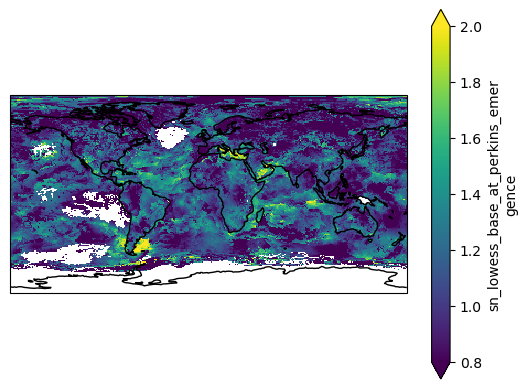

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
x_at_y_emergence_tree['best_tas'].to_dataset()['sn_lowess_base_at_perkins_emergence'].plot(vmin=0.8, vmax=2, ax=ax)
ax.coastlines()

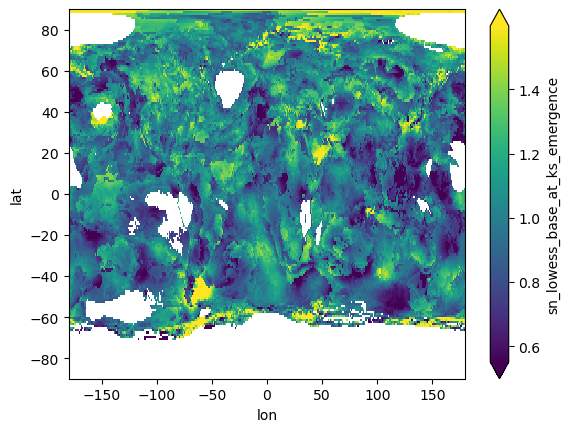

In [74]:
x_at_y_emergence_tree['best_tas'].to_dataset()['sn_lowess_base_at_ks_emergence'].plot(robust=True)

In [75]:
x_at_y_emergence_tree['best_tas'].to_dataset().mean().to_array()

<xarray.DataArray (variable: 56)> Size: 448B
array([67.60447337, 61.34777378, 64.3608325 , 60.27674238, 60.0968262 ,
       58.32651688, 57.13422266, 57.79564325, 41.184606  , 40.4493069 ,
       37.48615806, 41.41949197, 41.69590498, 43.33643705, 44.44368313,
       43.80687821, 60.29588334, 67.42594999, 61.17173567, 64.1994366 ,
       59.74009032, 58.11204886, 56.95595981, 57.59610656,  0.99935504,
        0.67269423,  1.00075136,  0.88448532,  1.00322625,  1.18601473,
        1.2209433 ,  1.17518773,  0.91677661,  0.63014329,  0.90413754,
        0.79188117,  0.9270713 ,  0.94564969,  1.06548612,  1.03839883,
        0.90922132,  0.62718658,  0.88874073,  0.77852359,  0.91721513,
        0.92501955,  1.01177045,  1.02767205,  0.93270392,  0.6443831 ,
        0.90932686,  0.7986612 ,  0.94379446,  0.95296912,  1.04974729,
        1.0982339 ])
Coordinates:
  * variable  (variable) object 448B 'frac_at_hd_emergence' ... 'sn_mean_roll...

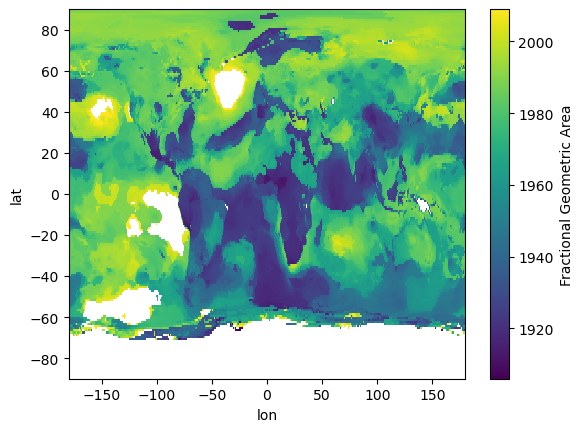

In [76]:
toe_tree.best_tas.frac.plot()

In [77]:
toe_frac_zero_tree

<xarray.DataTree>
Group: /
├── Group: /best_tas
│       Dimensions:  (lat: 180, lon: 360)
│       Coordinates:
│         * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
│         * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
│       Data variables:
│           frac     (lat, lon) float64 518kB nan nan nan nan nan ... nan nan nan nan
└── Group: /access_ssp585_tas
        Dimensions:  (lat: 72, lon: 144, member: 40)
        Coordinates:
            height   float64 8B 2.0
          * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
          * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
          * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
        Data variables:
            frac     (member, lat, lon) float64 3MB 2.075e+03 2.075e+03 ... 2.038e+03

In [78]:
val_of_x_at_toe_of_y

<function __main__.val_of_x_at_toe_of_y(toe_metric_da, toe_da)>

In [79]:
sn_at_zero_overlap = val_of_x_at_toe_of_y(
    toe_metric_tree.access_ssp585_tas.sn_lowess_base,
    toe_frac_zero_tree.access_ssp585_tas
).compute().to_array()

sn_at_zero_overlap.name = 'sn_lowess_base'

In [80]:
sn_at_50_overlap = val_of_x_at_toe_of_y(
    toe_metric_tree.access_ssp585_tas.sn_lowess_base,
    toe_frac_50_tree.access_ssp585_tas
).compute().to_array()

sn_at_50_overlap.name = 'sn_lowess_base'

In [81]:
sn_at_zero_overlap.median(), sn_at_50_overlap.median()

(<xarray.DataArray 'sn_lowess_base' ()> Size: 8B
 array(6.28494589)
 Coordinates:
     height   float64 8B 2.0,
 <xarray.DataArray 'sn_lowess_base' ()> Size: 8B
 array(1.53434345)
 Coordinates:
     height   float64 8B 2.0)

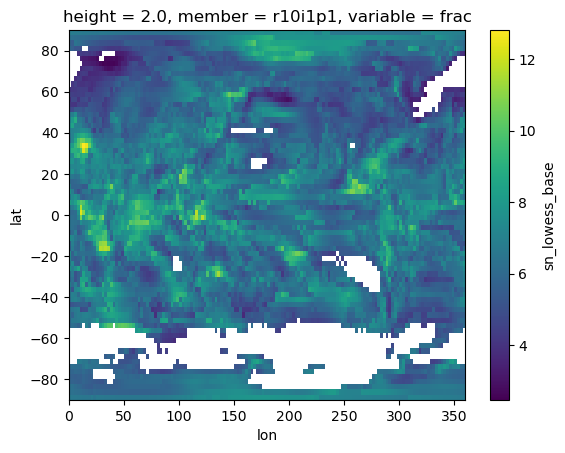

In [82]:
sn_at_zero_overlap.isel(member=0).plot()#.plot()

<h2 style='color:cyan'> Plots </h2>

<h3 style='color:green; background-color:palegoldenrod; padding:10px; border-radius:5px;'> Set-up </h3>


In [251]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from dataclasses import dataclass
from toe_plots import test_colors
from plotting_utils import create_discrete_colorbar, style_plot
from toe_plots import percent_emerged_series, METRIC_MAP,NAME_MAPPING

In [84]:
@dataclass
class PlotLevels:
    start: int
    stop: int
    step: int

    def generate_range(self):
        """Generate a numpy array based on the start, stop, and step."""
        return np.arange(self.start, self.stop, self.step)

In [85]:
std_cmap = 'OrRd'
std_levels = np.arange(0, 2.75, .25)

In [86]:
main_tests = ['sn_lowess_base', 'ks', 'frac']#'ttest', 'perkins', 'frac', 'hd']

In [87]:
# Create a custom colormap with two colors: gray and transparent
colors = [(0, 0, 0, 0), (0.5, 0.5, 0.5, 1)]  # (R, G, B, Alpha)
cmap_binary = mcolors.LinearSegmentedColormap.from_list("binary_no_color", colors)

In [146]:
start = toe_metric_tree.best_tas.time.dt.year.values[0]-5
step = 10

PLOT_LEVELS = {
    # 'best_tas': PlotLevels(start=start, stop=2020+5, step=10).generate_range(),
    'access_ssp585_tas':PlotLevels(start=start, stop=2100+step, step=step).generate_range()
}

# PLOT_LEVELS = {
#     item: LEVEL_TYPES['cesm1'] if 'access' in item else PLOT_LEVELS['historical']
#     for item in list(toe_tree)
# }

PLOT_LEVELS['best_tas'] = PLOT_LEVELS['access_ssp585_tas']
PLOT_LEVELS

{'access_ssp585_tas': array([1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990,
        2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]),
 'best_tas': array([1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990,
        2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100])}

In [140]:
toe_metrics_list = list(toe_tree[list(toe_tree)[0]])
toe_metrics_list

['frac',
 'hd',
 'ks',
 'perkins',
 'sn_hawkins_base',
 'sn_hawkins_full',
 'sn_lowess_base',
 'sn_lowess_full',
 'sn_mean',
 'sn_mean_roll',
 'ttest']

In [91]:
vars_of_interest = list(toe_tree)#['best_tas', ]'era5_2t', 'best_tas', 'era5_rx1d']
vars_of_interest

['best_tas', 'access_ssp585_tas']

In [92]:
toe_tree = toe_tree.compute()
sign_tf_tree = sign_tf_tree.compute()

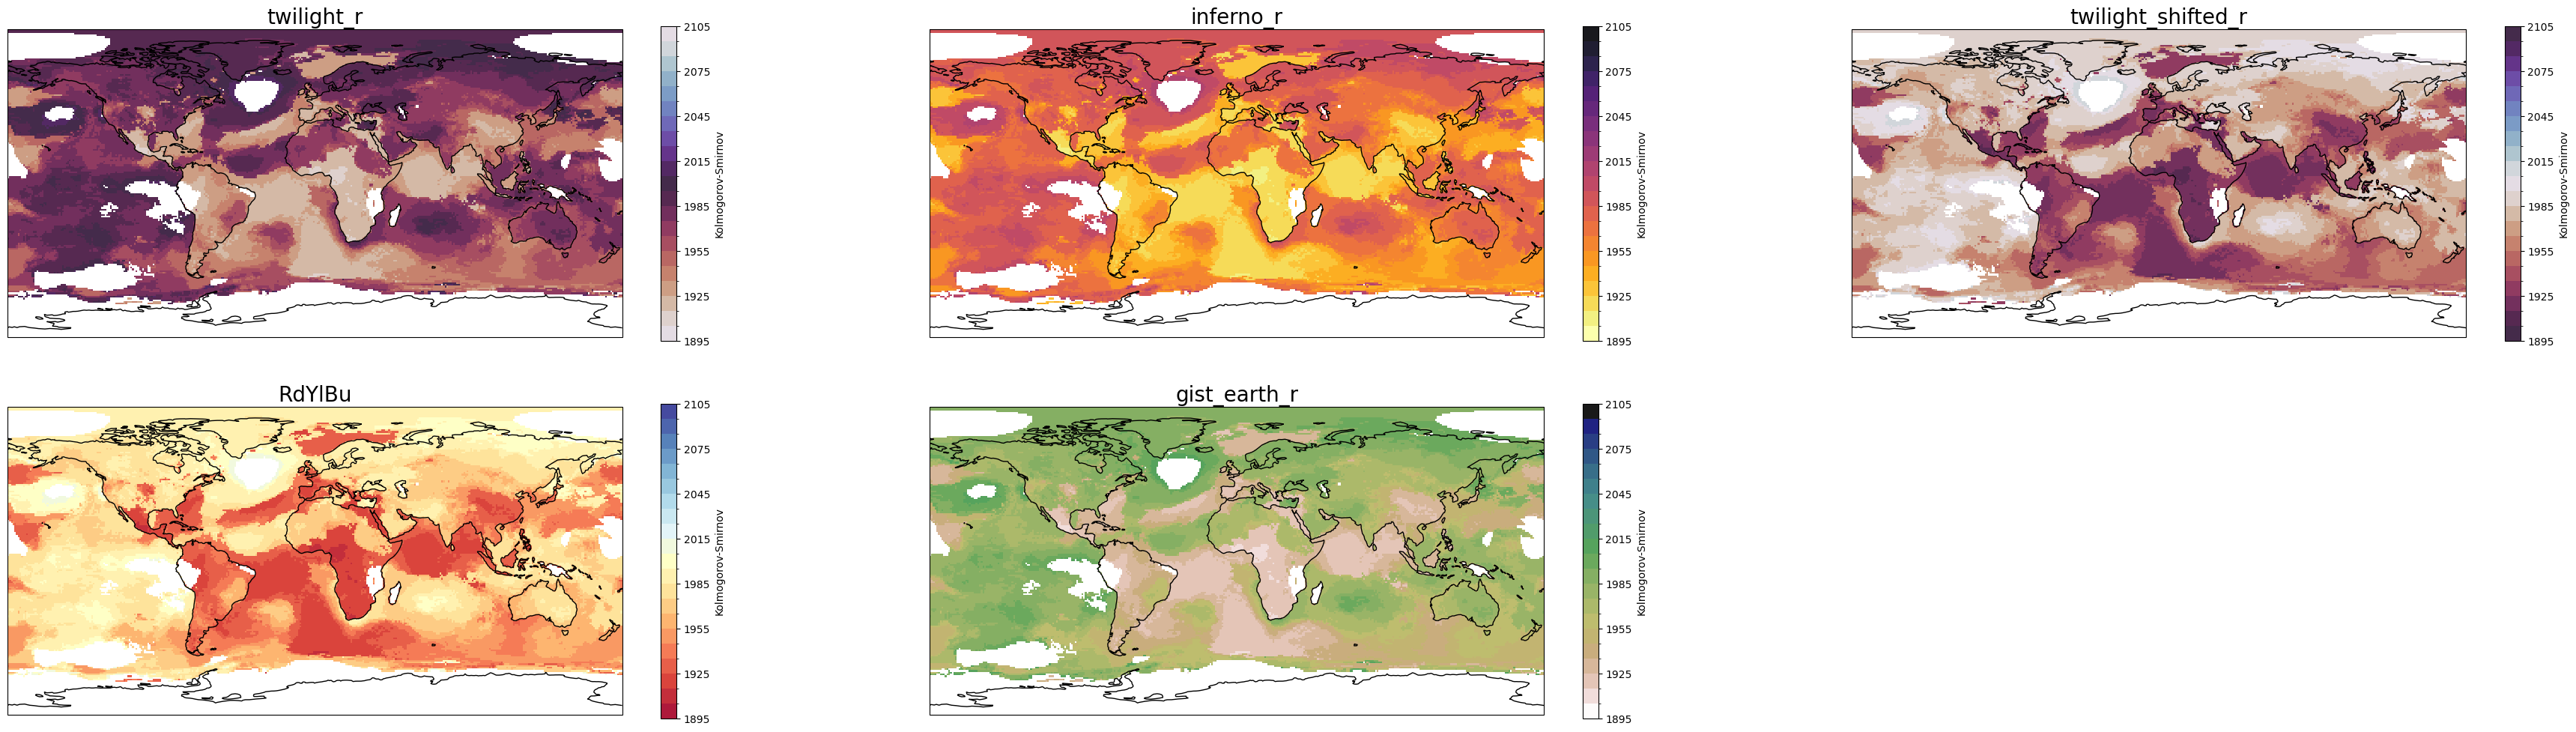

In [93]:
# colormap_list = plt.colormaps()
colormap_list = ['twilight_r', 'inferno_r', 'twilight_shifted_r', 'RdYlBu', 'gist_earth_r']
# Number of columns and rows for subplots
ncols = 3
nrows = int(np.ceil(len(colormap_list) / ncols))

# Adjust the figure size dynamically
fig = plt.figure(figsize=(ncols * 15, nrows *6))

for num, cmap in enumerate(colormap_list):
    # Calculate the subplot index
    row = num // ncols
    col = num % ncols
    ax = fig.add_subplot(nrows, ncols, num + 1, projection=ccrs.PlateCarree())
    
    toe_tree.best_tas.ks.plot(ax=ax, cmap=cmap, levels=PLOT_LEVELS['best_tas'], alpha=0.9)
    
    ax.coastlines()
    ax.set_title(cmap, fontsize=20)  # Add colormap name as title

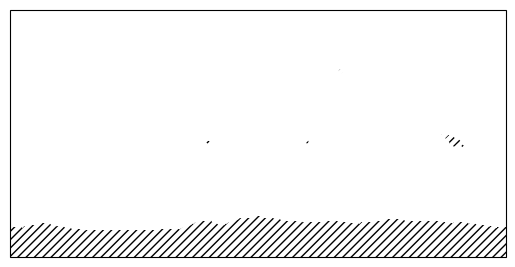

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
plotting_utils.hatch(ax, data_availability_tree.best_tas.to_dataset().to_array().squeeze(),
                     **plotting_utils.not_stable_kwargs)

In [95]:
np.array(list(toe_metrics_list))

array(['frac', 'hd', 'ks', 'perkins', 'sn_hawkins_base',
       'sn_hawkins_full', 'sn_lowess_base', 'sn_lowess_full', 'sn_mean',
       'sn_mean_roll', 'ttest'], dtype='<U15')

<h3 style='color:green'>  Large Ensemble Sample Plots </h3>

#### ToE of data

In [96]:
le_pi_ds_noise = le_pi_ds.std(dim='time').compute()

In [97]:
# Noise of just the base period
cesm1_noise_base_period = (signal_tree
                           .access_ssp585_tas.to_dataset()
                           .noise_lowess
                           .isel(time=slice(0,30))
                           .std(dim='time')
                           .median(dim='member')
                           .compute()
                           )

# Noise of the whole series
cesm1_noise_full = (signal_tree
                    .access_ssp585_tas.to_dataset()
                    .noise_lowess
                    .std(dim='time')
                    .median(dim='member')
                    .compute()
                   )

In [98]:
std_levels = np.arange(0, 2.1, .1)
std_cmap = plt.cm.terrain_r

In [99]:
le_pi_ds_noise

<xarray.DataArray 'tas' (lat: 192, lon: 288)> Size: 221kB
array([[0.6689777 , 0.66897374, 0.66897774, ..., 0.6689754 , 0.66897655,
        0.66897833],
       [0.7082914 , 0.7080774 , 0.7078604 , ..., 0.70880926, 0.7086572 ,
        0.7085116 ],
       [0.7311221 , 0.7306385 , 0.7301185 , ..., 0.73255366, 0.7320958 ,
        0.7316055 ],
       ...,
       [0.9285563 , 0.9304134 , 0.9321571 , ..., 0.9236293 , 0.92524654,
        0.9268131 ],
       [0.9090376 , 0.9097421 , 0.9104527 , ..., 0.90676695, 0.9075542 ,
        0.90831137],
       [0.89531994, 0.8953748 , 0.8954251 , ..., 0.8951355 , 0.89520466,
        0.89526963]], dtype=float32)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [100]:
cesm1_noise_base_period#/le_pi_ds_noise

<xarray.DataArray 'noise_lowess' (lat: 72, lon: 144)> Size: 83kB
array([[0.77677275, 0.7755796 , 0.77706757, ..., 0.77635417, 0.7766892 ,
        0.77693023],
       [0.81787244, 0.82786259, 0.83662205, ..., 0.79281865, 0.79856968,
        0.8076005 ],
       [0.88358311, 0.88783061, 0.90984744, ..., 0.86747472, 0.87586802,
        0.88397935],
       ...,
       [1.24417317, 1.27317026, 1.31478178, ..., 1.11081224, 1.16252751,
        1.20837689],
       [1.05281414, 1.05965664, 1.06561037, ..., 1.02843675, 1.04345934,
        1.04864805],
       [0.95683747, 0.95983717, 0.96417612, ..., 0.9477956 , 0.95128807,
        0.95429613]])
Coordinates:
    height   float64 8B 2.0
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8

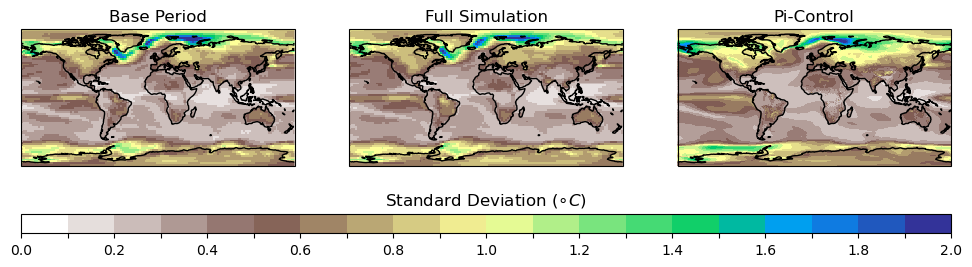

In [101]:
fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 0.1])

axes = [fig.add_subplot(gs[i], projection=ccrs.PlateCarree()) for i in range(3)]

plot_kwargs = dict(add_colorbar=False, levels=std_levels, cmap=std_cmap)

cesm1_noise_base_period.plot(ax=axes[0], **plot_kwargs)
cesm1_noise_full.plot(ax=axes[1], **plot_kwargs)
le_pi_ds_noise.plot(ax=axes[2], **plot_kwargs)


axes[0].set_title('Base Period')
axes[1].set_title('Full Simulation')
axes[2].set_title('Pi-Control')

[ax.coastlines() for ax in axes];

cbar1 = plotting_utils.create_discrete_colorbar(
        std_cmap, std_levels, plt.subplot(gs[-1, :]) ,
        r'Standard Deviation ' + r'$(\circ C)$', fontscale=1, orientation='horizontal', pad=7,
    tick_slice = slice(None, None, 2)
    )

In [102]:
signal_tree.access_ssp585_tas.to_dataset()

<xarray.Dataset> Size: 3GB
Dimensions:        (member: 40, lat: 72, lon: 144, time: 221)
Coordinates:
    height         float64 8B ...
  * lat            (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon            (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * member         (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time           (time) object 2kB 1880-12-31 00:00:00 ... 2100-12-31 00:00:00
Data variables:
    noise_lowess   (member, lat, lon, time) float64 733MB dask.array<chunksize=(1, 72, 144, 221), meta=np.ndarray>
    noise_rolling  (member, lat, lon, time) float64 733MB dask.array<chunksize=(1, 72, 144, 221), meta=np.ndarray>
    signal_lowess  (member, lat, lon, time) float64 733MB dask.array<chunksize=(1, 72, 144, 221), meta=np.ndarray>
    signal_mean    (member, lat, lon, time) float64 733MB dask.array<chunksize=(1, 72, 144, 221), meta=np.ndarray>
Attributes:
    name:     access_ssp585_tas

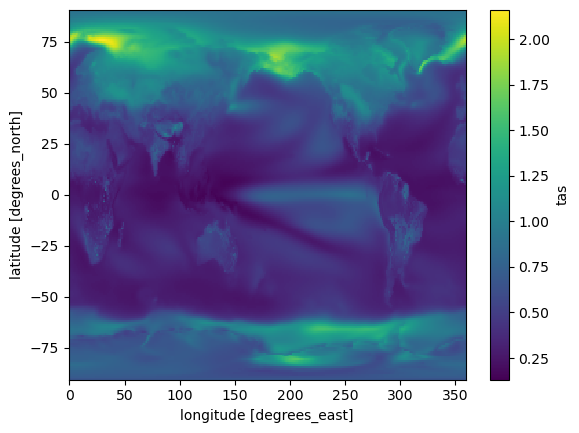

In [103]:
le_pi_ds_noise.plot()

In [104]:
data_tree.access_ssp585_tas.to_dataset().tas.sel(**loc).compute(), le_pi_ds

NameError: name 'loc' is not defined

#### Testing

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
def find_best_ar_order(time_series, max_order=10, criterion='aic', verbose=True):
    """
    Determine the best AR order for a given time series using AIC or BIC.
    
    Parameters:
    - time_series: array-like, the input time series data.
    - max_order: int, the maximum AR order to test (default: 10).
    - criterion: str, either 'aic' or 'bic' to determine the best order.
    - verbose: bool, prints additional debug info if True.
    
    Returns:
    - best_order: int, the optimal AR order based on the selected criterion.
    """
    best_order = None
    best_value = np.inf  # Start with a very large value
    
    # Ensure time_series is a NumPy array
    time_series = np.asarray(time_series)

    # Check for missing values
    if np.any(np.isnan(time_series)):
        raise ValueError("Time series contains NaN values. Please remove or interpolate missing data.")

    # Ensure stationarity using Augmented Dickey-Fuller Test
    adf_pval = sm.tsa.adfuller(time_series)[1]  # Extract p-value
    if adf_pval > 0.05:
        raise ValueError("Time series appears non-stationary (ADF p-value > 0.05). Consider differencing.")

    # Test AR orders
    for p in range(1, max_order + 1):
        try:
            model = ARIMA(time_series, order=(p, 0, 0))  # AR(p) model
            result = model.fit()
            
            # Select the criterion
            value = result.aic if criterion == 'aic' else result.bic
            
            if verbose:
                print(f"AR({p}): {criterion.upper()} = {value:.2f}")

            # Update best order if the criterion is lower
            if value < best_value:
                best_value = value
                best_order = p
        except Exception as e:
            if verbose:
                print(f"Failed to fit AR({p}): {e}")
    
    if best_order is None:
        raise RuntimeError("No valid AR model could be fitted. Try lowering max_order or checking data quality.")
    
    return best_order

In [ ]:
import numpy as np
import statsmodels.api as sm

def newey_west_variance(data, max_lag=9):
    """
    Compute the Newey-West variance estimator for an AR(5) process.
    
    Parameters:
    - data: array-like, time series data.
    - max_lag: int, maximum lag to consider (default is 5 for AR(5)).
    
    Returns:
    - Newey-West variance estimate.
    """
    data = np.asarray(data)
    n = len(data)
    
    # Compute residuals from an OLS model (or use pre-fitted residuals)
    X = sm.add_constant(np.arange(n))  # Simple trend model (change if needed)
    model = sm.OLS(data, X).fit()
    residuals = model.resid
    
    # Compute gamma_0 (variance) and gamma_k (covariances)
    gamma_0 = np.var(residuals, ddof=1)
    gamma_k = [np.cov(residuals[:-k], residuals[k:], ddof=1)[0, 1] for k in range(1, max_lag + 1)]
    
    # Bartlett weights: w_k = 1 - k / (max_lag + 1)
    weights = [1 - k / (max_lag + 1) for k in range(1, max_lag + 1)]
    
    # Compute Newey-West variance estimate
    newey_west_var = gamma_0 + 2 * np.sum(np.array(weights) * np.array(gamma_k))
    
    return newey_west_var

# Example usage with synthetic AR(5) data
# np.random.seed(42)
# n = 500
# ar_params = [0.3, -0.2, 0.1, 0.05, -0.02]  # AR(5) coefficients
# ma_params = []  # No MA terms
# ar = np.r_[1, -np.array(ar_params)]  # Include leading 1
# ma = np.r_[1, np.array(ma_params)]
# data = sm.tsa.arma_generate_sample(ar, ma, n)

# # Compute Newey-West variance
# nw_var = newey_west_variance(data)
# print(f"Newey-West Variance Estimate: {nw_var:.5f}")


In [ ]:
loc = dict(lat=90, lon=145, method='nearest')

In [ ]:
data_tree.access_ssp585_tas.to_dataset().tas.sel(**loc).compute()

In [ ]:
le_pi_loc_ds = le_pi_ds.sel(**loc).compute() 
le_pi_loc_ds = le_pi_loc_ds - le_pi_loc_ds.mean()

In [ ]:
# std_ar5 = np.sqrt(np.var(le_pi_loc_ds.values, ddof=5))

In [ ]:
np.var(le_pi_loc_ds).values

In [ ]:
autocorr_std = np.sqrt(newey_west_variance(le_pi_loc_ds.values))
autocorr_std

In [ ]:
from statsmodels.tsa.stattools import acovf

# Compute long-run variance
acf_values = acovf(le_pi_loc_ds, fft=True)
long_run_variance = acf_values[0] + 2 * np.sum(acf_values[1:])

print(f"Long-Run Variance Estimate: {long_run_variance:.4f}")

In [ ]:
from statsmodels.tsa.stattools import acovf

acf_values = acovf(le_pi_loc_ds, fft=True)

# Compute long-run variance by summing correctly
long_run_variance_fixed = acf_values[0] + 2 * np.sum(acf_values[1:10])  # Sum first 10 lags

print(f"Manually Computed Long-Run Variance: {long_run_variance_fixed:.4f}")


In [ ]:
long_run_variance

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(le_pi_loc_ds, lags=20);

In [ ]:
le_pi_loc_ds.plot()

In [ ]:
find_best_ar_order(le_pi_loc_ds)

In [ ]:
signal_le_loc_ds = signal_tree.access_ssp585_tas.to_dataset().signal_lowess.sel(**loc).compute()

In [ ]:
le_toe_ds = toe_tree.access_ssp585_tas.to_dataset().sel(**loc)
le_metric_ds = toe_metric_tree.access_ssp585_tas.to_dataset().sel(**loc)

In [ ]:
noise_le_loc = le_pi_loc_ds.std().values.item()
noise_le_loc

In [ ]:
sn_pi_le_loc_ds = signal_le_loc_ds/noise_le_loc

In [ ]:
sn_pi_toe_loc_ds = toe_calc.get_permanent_exceedance(sn_pi_le_loc_ds, threshold=1, comparison_func=np.greater)

In [ ]:
signal_data_median = data_tree_le_loc.mean(dim='member')

In [ ]:
toe_other = toe_calc.get_permanent_exceedance(
    signal_data_median, threshold=1, comparison_func=np.greater).values.item()
toe_other

In [ ]:
toe_sn_median = sn_pi_toe_loc_ds.median().values.item()
toe_sn_median

In [ ]:
noise_le_loc, autocorr_std

In [ ]:
fig = plt.figure()

axes = [fig.add_subplot(211), fig.add_subplot(212)]

ax = axes[0]
time = data_tree_le_loc.time.values
ax.plot(time, signal_data_median, label='Ensemble Mean')


ax.fill_between(time, -np.tile(autocorr_std, len(time)), np.tile(autocorr_std, len(time)),
               color='purple', alpha=0.5, label=r'$1 \sigma$ form pi-Control')

ax.fill_between(time, -np.tile(noise_le_loc, len(time)), np.tile(noise_le_loc, len(time)),
               color='black', alpha=0.5, label=r'$1 \sigma$ form pi-Control')



ax.set_title('Signal = Ensemble Mean (n=40)')
ax.annotate(f'ToE = {toe_other:.0f}', xy=(0.01, 0.8), ha='left', va='center', xycoords='axes fraction')

ax.legend()

ax2 = axes[1]
sn_pi_le_loc_ds.plot(hue='member', add_legend=False);
ax2.axhline(1, linestyle='--');

ax2.set_title('Signal = LOWESS of each member')
ax2.annotate(f'ToE = {toe_sn_median:.0f}', xy=(0.01, 0.8), ha='left', va='center', xycoords='axes fraction')


for ax in axes:
    ax.set_ylabel('S/N Ratio')

plt.tight_layout()

In [ ]:
x = np.linspace(1940, 2100, 1000)

In [ ]:
le_toe_kds_ds = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    le_toe_ds,
    kwargs=dict(x=x),
    input_core_dims=[['member']],
    output_core_dims=[['x']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float],
    dask_gufunc_kwargs={'output_sizes':{'x': len(x)}}
).assign_coords(x=x).compute()

# le_kds_ds['x'] = x

In [ ]:
data_tree_le_loc.plot(hue='member', add_legend=False);

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
for toe_metric in list(le_ds[main_tests]):
    le_da = le_ds[toe_metric]
    le_toe_kds_ds[toe_metric].plot(ax=ax, alpha=0.5, label=toe_metric)

ax.legend()

In [ ]:
toe_metric_tree.access_ssp585_tas.to_dataset().sel(**loc).sn_lowess_base.plot(hue='member', add_legend=False);

In [ ]:
toe_metric_tree.access_ssp585_tas.to_dataset().sel(**loc).sn_lowess_base.plot(hue='member', add_legend=False);

<h3 style='color:green'> Maps and Time series</h3>

In [105]:
test_vars = vars_of_interest#['best_tas', 'era5_2t', 'best_tas', 'era5_tx99p9count']

In [106]:
main_tests

['sn_lowess_base', 'ks', 'frac']

In [107]:
vars_with_multi_thresh2 = ['frac', 'hd', 'perkins','sn_lowess_base', ]

In [108]:
reload(toe_plots)

<module 'toe_plots' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_plots.py'>

In [109]:
vars_with_multi_thresh

['frac',
 'hd',
 'perkins',
 'sn_lowess_base',
 'sn_lowess_full',
 'sn_mean',
 'sn_mean_roll']

In [110]:
reload(toe_plots)

<module 'toe_plots' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_plots.py'>

Text(0.5, 1.02, 'Unknown')

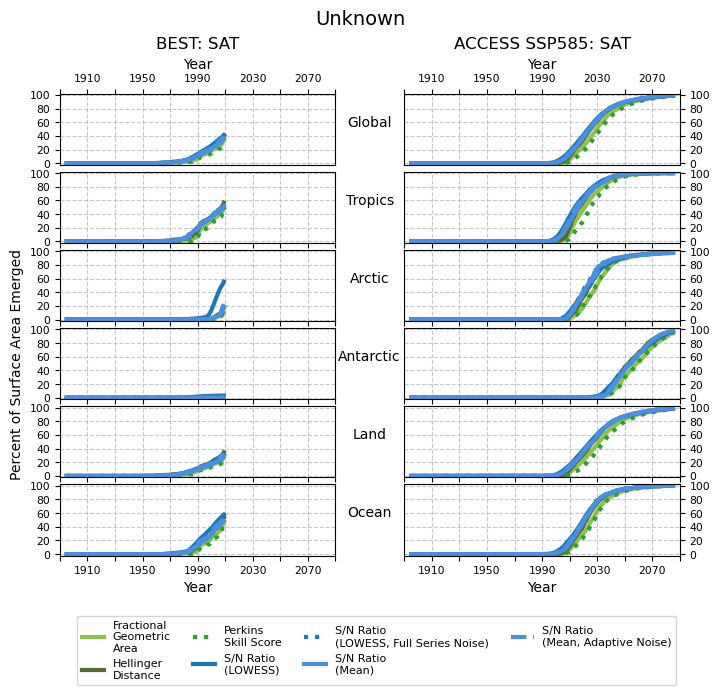

In [626]:
# regions = percent_time_ds.region.values

tests_var_used = test_vars[:2]
regions = np.array(['global', 'tropics','arctic', 'antarctic', 'land', 'ocean'])

fig = plt.figure(figsize=(4*len(tests_var_used), len(regions)))
gs = gridspec.GridSpec(len(regions), len(tests_var_used), hspace=.1, wspace=.25)

axes = []
for column, var in enumerate(tests_var_used):
    percent_time_ds = emergence_time_series_unknown_tree[var].to_dataset()
    
    axes_column = [fig.add_subplot(gs[i, column]) for i in range(len(regions))]

    for row, region in enumerate(regions):
        ax = axes_column[row]
        percent_time_region_ds = percent_time_ds.sel(region=region)
        if 'member' in list(percent_time_ds.sel(region=region).coords):
            percent_time_region_ds = percent_time_region_ds.median(dim='member')
            
        toe_plots.percent_emerged_series(
            percent_time_region_ds, vars_with_multi_thresh, ax=ax,
            legend=False, fontscale=0.65, xticks=np.arange(1890, 2110, 20))

        if column == len(tests_var_used)-1: 
            ax.set_ylabel(toe_const.NAMING_MAP.get(region, region),
                          fontsize=10, rotation=0, labelpad=25)

        
        if column == len(tests_var_used)-1:
            ax.yaxis.tick_right()
        if row == 0:
            ax.xaxis.set_label_position('top')
            ax.xaxis.tick_top()
            ax.set_title(NAME_MAPPING.get(var, var))
            
        if row == 0 or row == len(regions)-1:
            ax.set_xlabel('Year', fontsize=10)
        else:
            ax.set_xlabel('')
            # ax.set_xticks([])
            ax.set_xticklabels([])

        if row == 3 and column == 0:
            ax.set_ylabel('Percent of Surface Area Emerged', fontsize=10)

    axes.append(axes_column)

axes_column[-1].legend(
    fontsize=8, loc='lower center', bbox_to_anchor=(-.1, -1.9),
    ncol=4)

fig.suptitle('Unknown', fontsize=14, y=1.02)

In [112]:
main_tests

['sn_lowess_base', 'ks', 'frac']

Text(0.5, 1.02, 'Unusual')

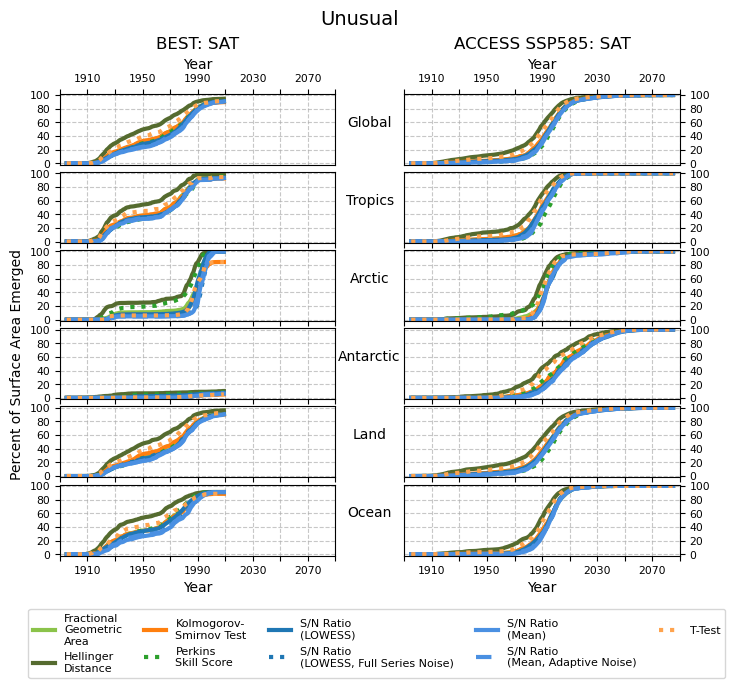

In [625]:
# regions = percent_time_ds.region.values

tests_var_used = test_vars#[:2]
test_met_used = [h for h in list(emergence_time_series_tree.best_tas) if 'hawkins' not in h]
regions = np.array(['global', 'tropics','arctic', 'antarctic', 'land', 'ocean'])

fig = plt.figure(figsize=(4*len(tests_var_used), len(regions)))
gs = gridspec.GridSpec(len(regions), len(tests_var_used), hspace=.1, wspace=.25)

axes = []
for column, var in enumerate(tests_var_used):
    percent_time_ds = emergence_time_series_tree[var].to_dataset()
    
    axes_column = [fig.add_subplot(gs[i, column]) for i in range(len(regions))]

    for row, region in enumerate(regions):
        ax = axes_column[row]

        percent_time_region_ds = percent_time_ds.sel(region=region)
        if 'member' in list(percent_time_region_ds.coords):
            percent_time_region_ds = percent_time_region_ds.median(dim='member')
            
        toe_plots.percent_emerged_series(percent_time_region_ds, test_met_used, ax=ax,
                              legend=False, fontscale=0.65, xticks=np.arange(1890, 2110, 20))

        if column == len(tests_var_used)-1: 
            ax.set_ylabel(toe_const.NAMING_MAP.get(region, region),
                          fontsize=10, rotation=0, labelpad=25)

        
        if column == len(tests_var_used)-1:
            ax.yaxis.tick_right()
        if row == 0:
            ax.xaxis.set_label_position('top')
            ax.xaxis.tick_top()
            ax.set_title(NAME_MAPPING.get(var, var))
            
        if row == 0 or row == len(regions)-1:
            ax.set_xlabel('Year', fontsize=10)
            # ax.set_xticklabels()
        else:
            ax.set_xlabel('')
            # ax.set_xticks([])
            ax.set_xticklabels([])

        if row == 3 and column == 0:
            ax.set_ylabel('Percent of Surface Area Emerged', fontsize=10)

    axes.append(axes_column)

axes_column[-1].legend(
    fontsize=8, loc='lower center', bbox_to_anchor=(-.1, -1.8),
    ncol=5)

fig.suptitle('Unusual', fontsize=14, y=1.02)

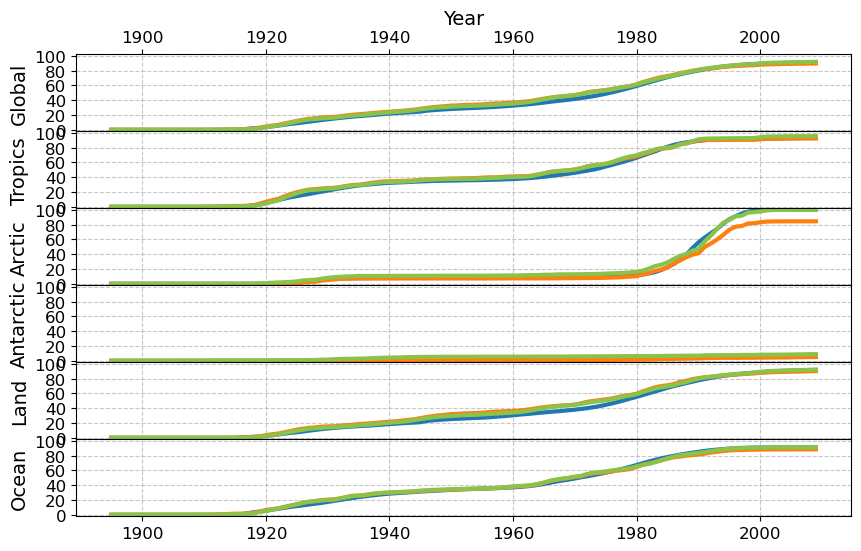

In [114]:
percent_time_ds = emergence_time_series_tree.best_tas.to_dataset()
# regions = percent_time_ds.region.values
regions = np.array(['global', 'tropics','arctic', 'antarctic', 'land', 'ocean'])

fig = plt.figure(figsize=(10, len(regions)))
gs = gridspec.GridSpec(len(regions), 1, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(len(regions))]

for num, region in enumerate(regions):
    ax = axes[num]
    toe_plots.percent_emerged_series(percent_time_ds.sel(region=region), main_tests, ax=ax,
                          legend=False)

    ax.set_ylabel(toe_const.NAMING_MAP.get(region, region), fontsize=14)

    if num == 0:
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
    if num == 0 or num == len(regions):
        ax.set_xlabel('Year', fontsize=14)

In [115]:
PLOT_LEVELS

{'best_tas': array([1895, 1905, 1915, 1925, 1935, 1945, 1955, 1965, 1975, 1985, 1995,
        2005, 2015, 2025, 2035, 2045, 2055, 2065, 2075, 2085, 2095, 2105]),
 'access_ssp585_tas': array([1895, 1905, 1915, 1925, 1935, 1945, 1955, 1965, 1975, 1985, 1995,
        2005, 2015, 2025, 2035, 2045, 2055, 2065, 2075, 2085, 2095, 2105])}

In [611]:
def plot_time_of_emergence_maps(
    toe_tree,
    emergence_time_series_tree,
    does_not_emerge_tree,
    data_availability_tree,
    # Default parameters
    tests_subset_used=None,
    tests_var_used=None,
    fontscale=1.1,
    cmap=plt.cm.RdYlBu,
    cmap_binary=None,
    toe_emergence_levels=None,

):
    """
    Plots time of emergence (ToE) maps and bottom-panel time series
    for a set of variables and metrics.

    Parameters
    ----------
    toe_tree : xarray Dataset or dict-like
        Your tree holding the time-of-emergence (ToE) data.
    emergence_time_series_tree : xarray Dataset or dict-like
        Tree holding global emergence time series data.
    does_not_emerge_tree : xarray Dataset or dict-like
        Holds data indicating where emergence does not occur.
    data_availability_tree : xarray Dataset or dict-like
        Indicates data availability.
    tests_subset_used : list, optional
        The metrics to be shown along the rows. Defaults to ['sn_lowess_base', 'ks', 'frac'].
    tests_var_used : list, optional
        The variables to be shown along the columns. Defaults to list of keys in toe_tree.
    fontscale : float, optional
        Scaling factor for fonts.
    cmap : matplotlib Colormap, optional
        Colormap to use for the ToE map. Defaults to plt.cm.RdYlBu.
    Returns
    -------
    fig : matplotlib Figure
        The generated figure.
    axes : 2D array of matplotlib Axes
        Axes for the map panels (shape = [len(tests_subset_used), len(tests_var_used)]).
    bottom_axes : list of matplotlib Axes
        Axes for the bottom time series panels.
    """
    # Default fallbacks if None

    if tests_var_used is None:
        tests_var_used = list(toe_tree.keys())
    if tests_subset_used is None:
        tests_subset_used = list(toe_tree[tests_var_used[0]])
    if cmap_binary is None:
        # Provide a default fallback or raise an error if necessary
        cmap_binary = plt.cm.binary

    fig = plt.figure(figsize=(6*len(list(tests_var_used)), 4.5*len(tests_subset_used)))
    gs  = gridspec.GridSpec(
        len(tests_subset_used)+2, len(tests_var_used),
        height_ratios = [1]*len(tests_subset_used)+[0.2]+[1],
        wspace=0.15, hspace=0.25
    )

    
    axes = np.array([
        [fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree()) for col in [0,1]]
        for row in range(len(tests_subset_used))
    ])
    
    bottom_axes = [fig.add_subplot(gs[-1, col]) for col in [0, 1]]#

    # caxes = [plt.subplot(gs[-2, col]) for col in [0, 1]]

    for col, variable in enumerate(tests_var_used):
        print(f"\nPlotting {variable}: ", end="")
        
        not_stable_kwargs2 = dict(
            cmap=cmap_binary, alpha=0.5, add_colorbar=False
        )
        toe_plot_kwargs = dict(
            add_colorbar=False, levels=PLOT_LEVELS.get(variable, np.arange(1920, 2030, 10))
        )

        for row, metric in enumerate(tests_subset_used):
            print(f"{metric} ", end="")

            ax = axes[row, col]

            toe_ds = toe_tree[variable].to_dataset()[metric]
            emergence_time_series_ds = (
                emergence_time_series_tree[variable]
                .to_dataset()
                .sel(region='global')
            )

            if 'member' in toe_ds.coords:
                toe_ds = toe_ds.median(dim='member')
            else:
                does_not_emerge_tree[variable].to_dataset()[metric].plot(
                    ax=ax, **not_stable_kwargs2
                )
                plotting_utils.hatch(
                    ax,
                    data_availability_tree[variable].to_dataset().to_array().squeeze(),
                    **plotting_utils.not_stable_kwargs
                )

            # Plot the ToE result
            toe_ds.plot(cmap=cmap, ax=ax, **toe_plot_kwargs)

            # Coastlines and lat markers
            ax.coastlines()
            add_lat_markers(ax, side='right')#side='left' if col==0 else 'right') #if col != 0: 

            # Row/column labels
            if col == 0:
                ax.annotate(
                    toe_plots.METRIC_MAP.get(metric, metric),
                    xy=(-0.17, 0.5),
                    xycoords='axes fraction',
                    rotation=0, ha='center', va='center',
                    fontsize=12*fontscale
                )
            else:
                ax.set_title('')
            if row == 0:
                ax.set_title(
                    NAME_MAPPING.get(variable, variable),
                    fontsize=14*fontscale
                )

        # Now add the time series in the bottom panel
        bax = bottom_axes[col]
        toe_plots.percent_emerged_series(
            (emergence_time_series_ds.median(dim='member')
              if 'member' in list(emergence_time_series_ds.coords)
              else emergence_time_series_ds),
            tests_subset_used,
            ax=bax, xticks=np.arange(1890, 2110, 20),
            legend=False, fontscale=fontscale)
        
    for bax in bottom_axes: bax.set_xlabel("Time", fontsize=14*fontscale)
    bottom_axes[0].set_ylabel("Percent of Surface\nArea Emerged", fontsize=14*fontscale)
    leg = bottom_axes[0].legend(ncol=4, loc='center', bbox_to_anchor=(1, -.5),
                                fontsize=10*fontscale)

    cbar1 = plotting_utils.create_discrete_colorbar(
        cmap, PLOT_LEVELS['best_tas'], plt.subplot(gs[-2, :]) ,
        'Time of Emergence', fontscale=fontscale, orientation='horizontal', pad=7
    )
    # cbar2 = plotting_utils.create_discrete_colorbar(
    #     cmap, PLOT_LEVELS['access_ssp585_tas'], caxes[1],
    #     'Time of Emergence', fontscale=fontscale, orientation='horizontal', pad=7,
    # )

    return fig, axes, bottom_axes

In [612]:
len(PLOT_LEVELS)

2

In [613]:
PLOT_LEVELS

{'access_ssp585_tas': array([1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990,
        2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]),
 'best_tas': array([1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990,
        2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100])}

In [614]:
all_tests = list(emergence_time_series_tree.access_ssp585_tas)
all_tests = ['sn_lowess_base', 'sn_mean', 'sn_mean_roll', 'ks', 'ttest', 'frac', 'perkins', 'hd']
all_tests_no_hyp = [t for t in all_tests if t not in ['ks', 'ttest']]


Plotting best_tas: sn_lowess_base ks frac 
Plotting access_ssp585_tas: sn_lowess_base ks frac 

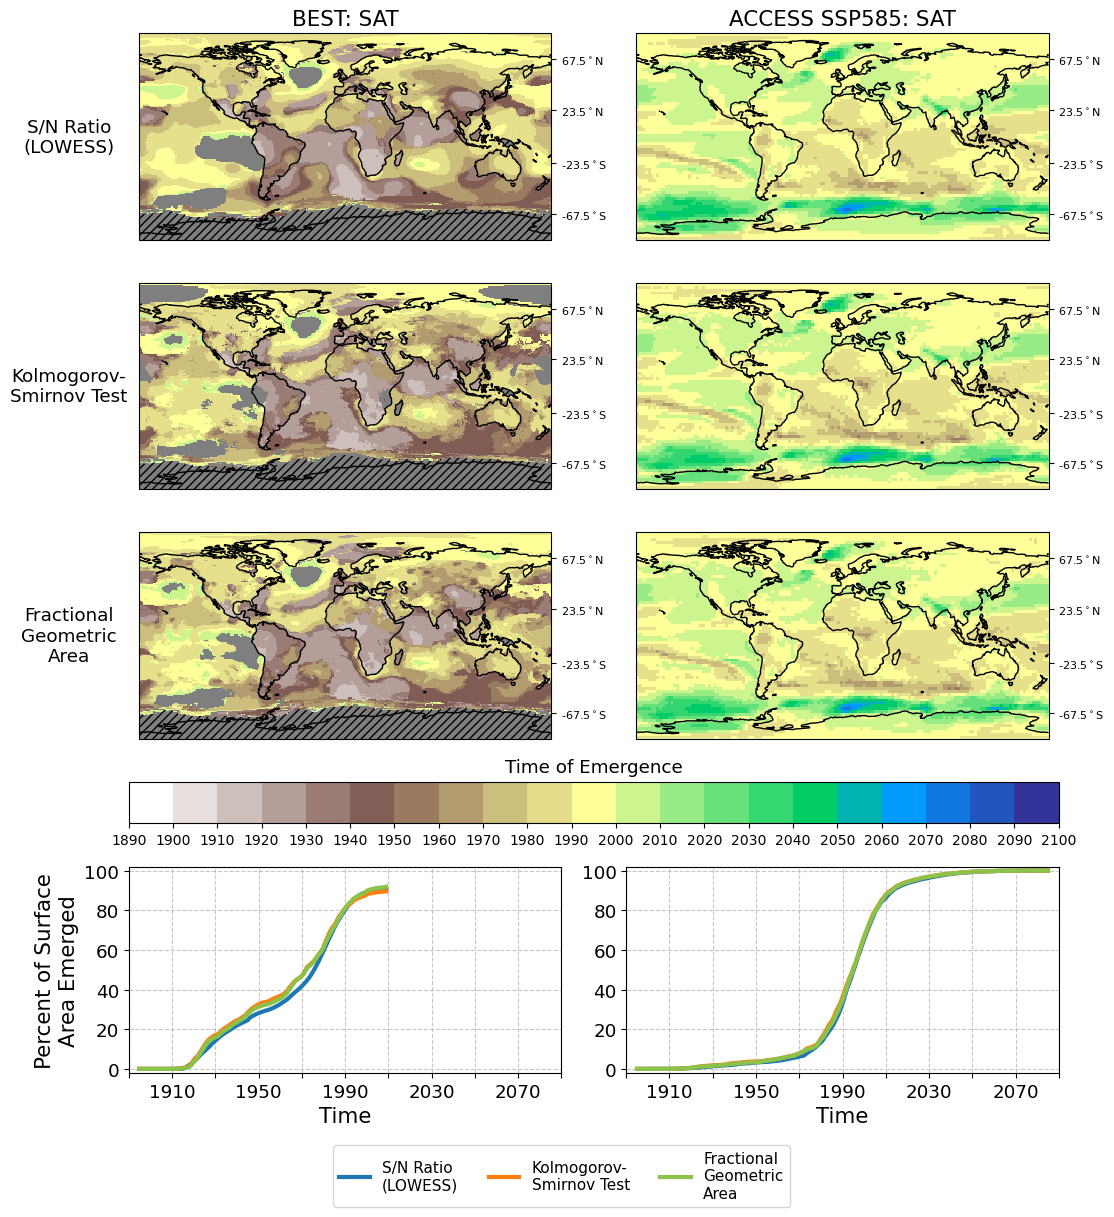

In [615]:
fig, axes, bottom_axes = plot_time_of_emergence_maps(
    toe_tree=toe_tree,
    emergence_time_series_tree=emergence_time_series_tree,
    does_not_emerge_tree=does_not_emerge_tree,
    data_availability_tree=data_availability_tree,
    tests_subset_used = main_tests,
    cmap=plt.cm.terrain_r
)

In [337]:
def plot_time_of_emergence_maps_single_var(
    toe_ds,
    does_not_emerge_ds,
    data_availability_ds,
    tests_subset_used=None,
    fontscale=1.1,
    levels:np.ndarray = np.arange(1920, 2030, 10),
    cmap=plt.cm.RdYlBu,
    toe_emergence_levels=None,
    fig = None,
    axes = None,
    cax  = None

):
    """
    Plots time of emergence (ToE) maps and bottom-panel time series
    for a single variable and multiple metrics.
    """

    if tests_subset_used is None:
        tests_subset_used = list(toe_ds[tests_var_used])

    if axes is None:
        ncol = 3
        num_rows = int(np.ceil(len(tests_subset_used)/ ncol))
        fig = plt.figure(figsize=(12, 3 * num_rows))
        gs = gridspec.GridSpec(
            num_rows + 1, ncol,
            height_ratios=[1] * num_rows + [0.1],
            wspace=0.15, hspace=0.05
        )
    
        axes = np.array(
            [fig.add_subplot(gs[num], projection=ccrs.PlateCarree()) for num in range(ncol*num_rows)])
    
        cax = plt.subplot(gs[-1, :])
    
    not_stable_kwargs2 = dict(
        cmap=cmap_binary, alpha=0.5, add_colorbar=False
    )
    toe_plot_kwargs = dict(
        add_colorbar=False, levels=levels,
    )

    for num, metric in enumerate(tests_subset_used):
        print(f"{metric} ", end="")

        ax = axes[num]

        does_not_emerge_ds[metric].plot(
            ax=ax, **not_stable_kwargs2
        )
        
        plotting_utils.hatch(
            ax,
            data_availability_ds.to_array().squeeze(),
            **plotting_utils.not_stable_kwargs
        )

        toe_ds[metric].plot(cmap=cmap, ax=ax, **toe_plot_kwargs)
        
        ax.coastlines()
        add_lat_markers(ax, side='right')

        ax.set_title(
            toe_plots.METRIC_MAP.get(metric, metric),
            fontsize=12 * fontscale
        )

    

    cbar1 = plotting_utils.create_discrete_colorbar(
        cmap, levels, cax,
        'Time of Emergence', fontscale=fontscale, orientation='horizontal', pad=7
    )


    return fig, axes, cax


In [316]:
def plot_time_of_emergence_maps_single_var_with_iqr(
    toe_ds,
    does_not_emerge_ds,
    data_availability_ds,
    tests_subset_used=None,
    fontscale=1.1,
    levels:np.ndarray = np.arange(1920, 2030, 10),
    iqr_levels:np.ndarray = np.arange(0, 16, 1),
    cmap=plt.cm.terrain,
):
    """
    Plots time of emergence (ToE) maps and bottom-panel time series
    for a single variable and multiple metrics.
    """

    if tests_subset_used is None: tests_subset_used = list(toe_ds[tests_var_used])

    ncols = 2
    nrows = len(tests_subset_used)
    fig = plt.figure(figsize=(3.5*ncols, 2 * nrows))
    gs = gridspec.GridSpec(2, 1, hspace=0.1, height_ratios=[1, 0.05], wspace=0.2)
    axes_gs = gridspec.GridSpecFromSubplotSpec(nrows, ncols, subplot_spec=gs[0])
    axes = np.array([
        [fig.add_subplot(axes_gs[row, col], projection=ccrs.PlateCarree())
         for col in range(ncols)] for row in range(nrows)])
    caxes_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[-1])
    caxes = [plt.subplot(caxes_gs[i]) for i in [-2, -1]]
    

    toe_plot_kwargs = dict(add_colorbar=False, levels=levels)

    toe_ds_iqr = (toe_ds.quantile(0.75, dim='member') - toe_ds.quantile(0.25, dim='member')).compute()

    for row, metric in enumerate(tests_subset_used):
        print(f"{metric} ", end="")

        toe_ds[metric].median(dim='member').plot(cmap=cmap, ax=axes[row, 0], **toe_plot_kwargs, extend='max')
        toe_ds_iqr[metric].plot(cmap=cmap, ax=axes[row, 1], levels=iqr_levels, add_colorbar=False, extend='max')

        
        axes[row, 0].annotate(
            toe_plots.METRIC_MAP.get(metric, metric), xy=(-0.24, 0.5),
            xycoords='axes fraction', rotation=0, ha='center', va='center',
            fontsize=10*fontscale)

        [axes[row, col].set_title('') for col in range(ncols)]


    cbar_kwargs = dict(fontscale=fontscale, orientation='horizontal', pad=7, extend='max')
    
    cbar1 = plotting_utils.create_discrete_colorbar(
        cmap, levels, caxes[0],'Time of Emergence', tick_slice=slice(None, None, 4) ,  **cbar_kwargs)
    cbar2 = plotting_utils.create_discrete_colorbar(
        cmap, iqr_levels, caxes[1],'Interquartile Range', tick_slice=slice(None, None, 4), **cbar_kwargs)

    axes[0, 0].set_title('Median')
    axes[0, 1].set_title('Inter-Quartile Range')
    
    for ax in axes.ravel():
        ax.coastlines()
        add_lat_markers(ax, side='right')
        
    return fig, axes, bottom_axes

In [346]:
best_metrics = [
    'sn_lowess_base', 'sn_lowess_full', 'sn_mean',
    'ks', 'ttest','frac', 'hd', 'perkins'] # 'sn_mean_roll'

In [347]:
coolest_metrics = [
    'sn_lowess_base', 'ks', 'ttest','frac', 'hd', 'perkins']

In [345]:
coolest_metrics_no_hype = [
    'sn_lowess_base','frac', 'hd', 'perkins']

In [349]:
best_metriccs_no_hype = [
    'sn_lowess_base', 'sn_lowess_full', 'sn_mean',
    'frac', 'hd', 'perkins'] #'sn_mean_roll'

In [350]:
iqr_levels = np.arange(0, 2*len(PLOT_LEVELS['access_ssp585_tas'])+2, 2)

sn_lowess_base ks ttest frac hd perkins 

Text(0.5, 0.92, 'Unusual')

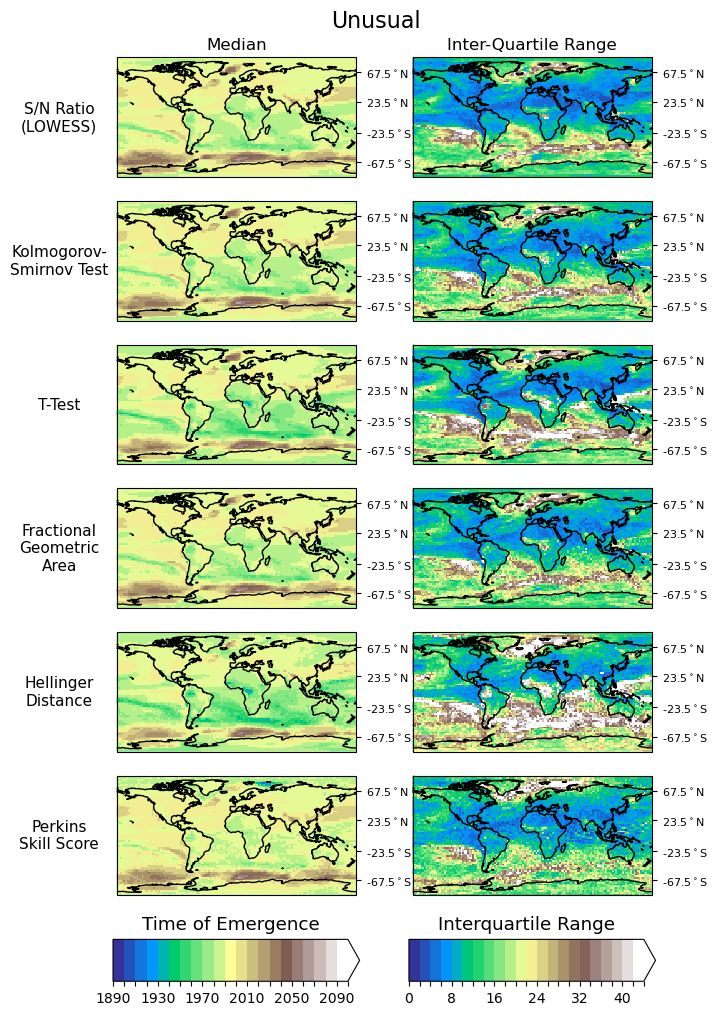

In [351]:
fig, axes, bottom_axes = plot_time_of_emergence_maps_single_var_with_iqr(
    toe_ds=toe_tree['access_ssp585_tas'].to_dataset(),
    does_not_emerge_ds=does_not_emerge_tree['access_ssp585_tas'].to_dataset(),
    data_availability_ds=data_availability_tree['access_ssp585_tas'].to_dataset(),
    tests_subset_used = coolest_metrics,
    levels = PLOT_LEVELS['access_ssp585_tas'],
    iqr_levels = iqr_levels
);
fig.suptitle('Unusual', fontsize=16, y=0.92)

sn_lowess_base frac hd perkins 

Text(0.5, 0.94, 'Unfamiliar')

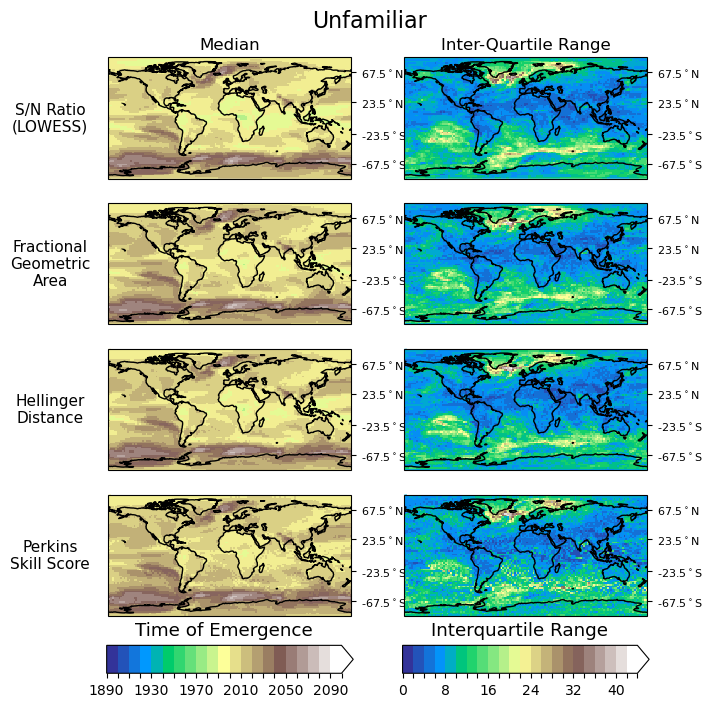

In [364]:
fig, axes, bottom_axes = plot_time_of_emergence_maps_single_var_with_iqr(
    toe_ds=toe_unfamiliar['access_ssp585_tas'].to_dataset(),
    does_not_emerge_ds=does_not_emerge_unfamiliar_tree['access_ssp585_tas'].to_dataset(),
    data_availability_ds=data_availability_tree['access_ssp585_tas'].to_dataset(),
    tests_subset_used = coolest_metrics_no_hype,
    levels = PLOT_LEVELS['access_ssp585_tas'],
    iqr_levels = iqr_levels
);
fig.suptitle('Unfamiliar', fontsize=16, y=0.94)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


sn_lowess_base frac hd perkins 

Text(0.5, 0.94, 'Unknown')

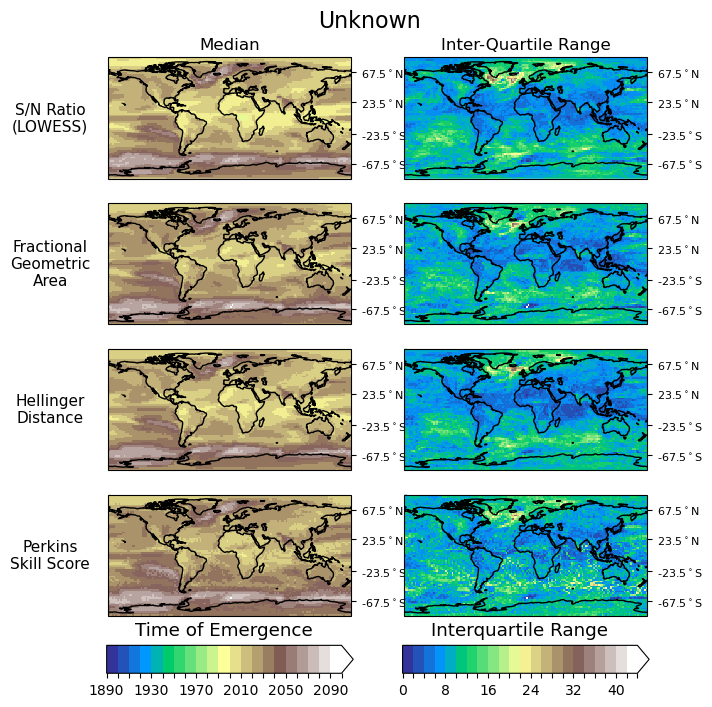

In [363]:
fig, axes, bottom_axes = plot_time_of_emergence_maps_single_var_with_iqr(
    toe_ds=toe_unknown['access_ssp585_tas'].to_dataset(),
    does_not_emerge_ds=does_not_emerge_unknown_tree['access_ssp585_tas'].to_dataset(),
    data_availability_ds=data_availability_tree['access_ssp585_tas'].to_dataset(),
    tests_subset_used = coolest_metrics_no_hype,
    levels = PLOT_LEVELS['access_ssp585_tas'],
    iqr_levels = iqr_levels
);

fig.suptitle('Unknown', fontsize=16, y=0.94)

In [355]:
# fig = plt.figure(figsize=(12, 3 * 2.5))
# gs = gridspec.GridSpec(
#     3 + 1, 3,
#     height_ratios=[1] * 3 + [0.1],
#     wspace=0.15, hspace=0.08
# )

# axes = np.array(
#     [fig.add_subplot(gs[num], projection=ccrs.PlateCarree()) for num in [0, 1,2, 4, 6, 7, 8]])

# cax = plt.subplot(gs[-1, :])



# fig, axes, bottom_axes = plot_time_of_emergence_maps_single_var(
#     toe_ds=toe_unfamiliar['best_tas'].to_dataset(),
#     does_not_emerge_ds=does_not_emerge_unfamiliar_tree['best_tas'].to_dataset(),
#     data_availability_ds=data_availability_tree['best_tas'].to_dataset(),
#     tests_subset_used = best_metriccs_no_hype,
#     levels = PLOT_LEVELS['best_tas'],
#     cmap=plt.cm.terrain_r, 
#     fig = fig, axes=axes, cax=cax
# )

# fig.suptitle('Unfamiliar', fontsize=16, y=0.95)

sn_lowess_base sn_lowess_full sn_mean frac hd perkins 

Text(0.5, 0.95, 'Unfamiliar')

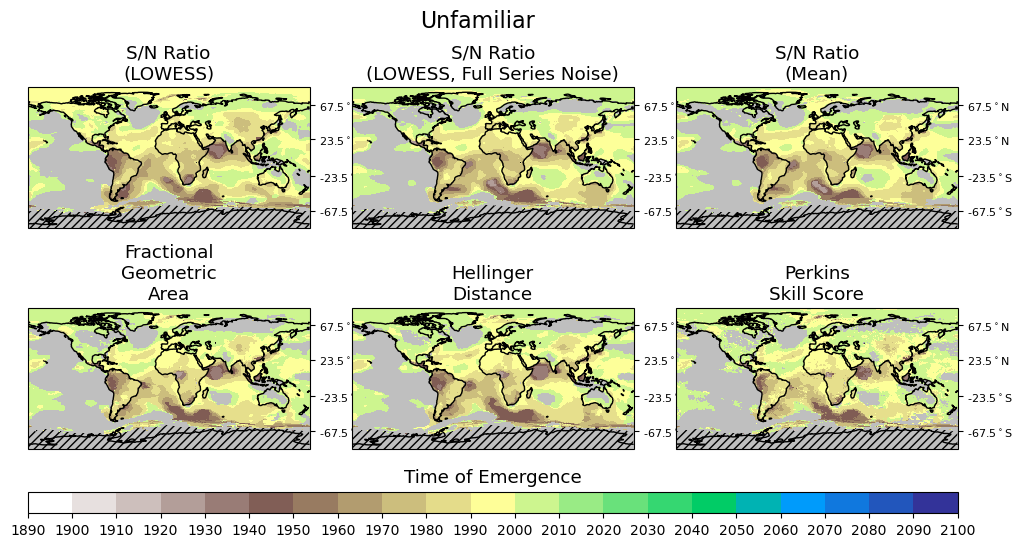

In [359]:
fig, axes, bottom_axes = plot_time_of_emergence_maps_single_var(
    toe_ds=toe_unfamiliar['best_tas'].to_dataset(),
    does_not_emerge_ds=does_not_emerge_unfamiliar_tree['best_tas'].to_dataset(),
    data_availability_ds=data_availability_tree['best_tas'].to_dataset(),
    tests_subset_used = best_metriccs_no_hype,
    levels = PLOT_LEVELS['best_tas'],
    cmap=plt.cm.terrain_r
)

fig.suptitle('Unfamiliar', fontsize=16, y=0.95)

sn_lowess_base sn_lowess_full sn_mean frac hd perkins 

Text(0.5, 0.95, 'Unfamiliar')

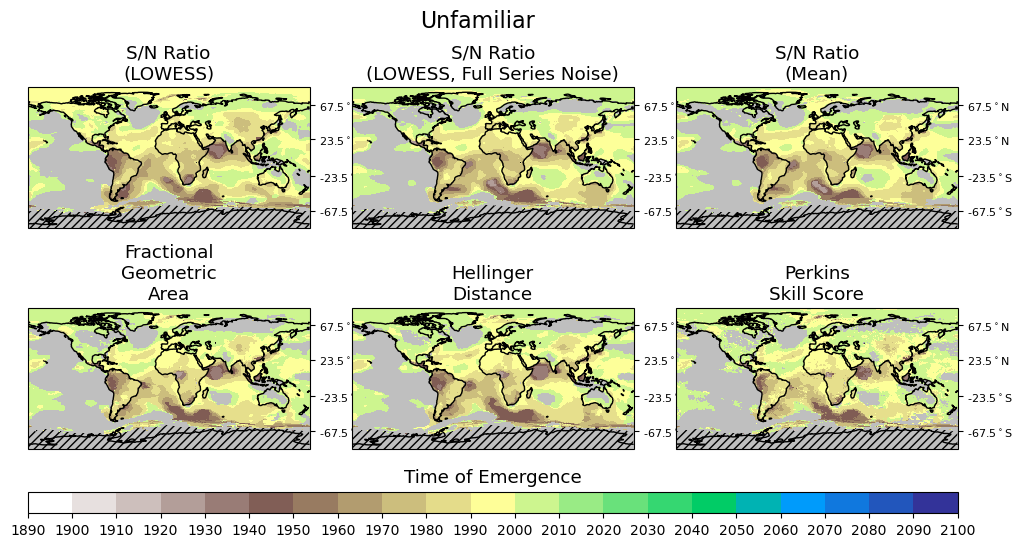

In [361]:
fig, axes, bottom_axes = plot_time_of_emergence_maps_single_var(
    toe_ds=toe_unfamiliar['best_tas'].to_dataset(),
    does_not_emerge_ds=does_not_emerge_unfamiliar_tree['best_tas'].to_dataset(),
    data_availability_ds=data_availability_tree['best_tas'].to_dataset(),
    tests_subset_used = best_metriccs_no_hype,
    levels = PLOT_LEVELS['best_tas'],
    cmap=plt.cm.terrain_r
)

fig.suptitle('Unfamiliar', fontsize=16, y=0.95)

sn_lowess_base sn_lowess_full sn_mean ks ttest frac hd perkins 

Text(0.5, 0.95, 'Unusual')

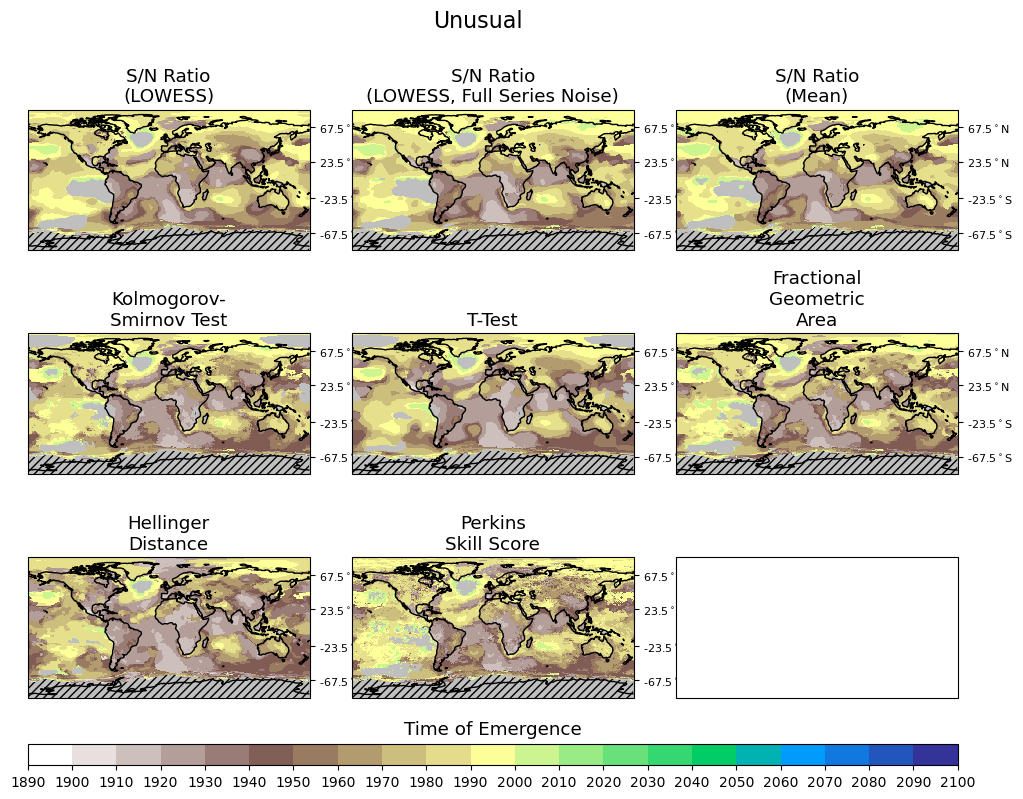

In [362]:
fig, axes, bottom_axes = plot_time_of_emergence_maps_single_var(
    toe_ds=toe_tree['best_tas'].to_dataset(),
    does_not_emerge_ds=does_not_emerge_tree['best_tas'].to_dataset(),
    data_availability_ds=data_availability_tree['best_tas'].to_dataset(),
    tests_subset_used = best_metrics,
    levels = PLOT_LEVELS['best_tas'],
    cmap=plt.cm.terrain_r
)

fig.suptitle('Unusual', fontsize=16, y=0.95)

In [261]:
# def plot_time_of_emergence_maps_single_var_with_uncertainty(
#     toe_ds,
#     does_not_emerge_ds,
#     data_availability_ds,
#     tests_subset_used=None,
#     fontscale=1.1,
#     levels:np.ndarray = np.arange(1920, 2030, 10),
#     cmap=plt.cm.RdYlBu,
#     toe_emergence_levels=None,
# ):
#     """
#     Plots time of emergence (ToE) maps and bottom-panel time series
#     for a single variable and multiple metrics.
#     """

#     if tests_subset_used is None:
#         tests_subset_used = list(toe_ds[tests_var_used])

#     ncol = 3
#     nrows = len(tests_subset_used)
#     fig = plt.figure(figsize=(12, 2 * nrows))

#     gs = gridspec.GridSpec(2, 1, hspace=0.1, height_ratios=[1, 0.05])

#     axes_gs = gridspec.GridSpecFromSubplotSpec(nrows, ncols, subplot_spec=gs[0])

#     axes = np.array([
#         [fig.add_subplot(axes_gs[row, col], projection=ccrs.PlateCarree())
#          for col in range(ncols)] for row in range(nrows)])
    
#     cax = plt.subplot(gs[-1])
    

#     not_stable_kwargs2 = dict(
#         cmap=cmap_binary, alpha=0.5, add_colorbar=False
#     )
#     toe_plot_kwargs = dict(
#         add_colorbar=False, levels=levels,
#     )

#     for row, metric in enumerate(tests_subset_used):
#         print(f"{metric} ", end="")

#         toe_ds[metric].median(dim='member').plot(cmap=cmap, ax=axes[row, 0], **toe_plot_kwargs)
#         toe_ds[metric].quantile(0.1, dim='member').plot(cmap=cmap, ax=axes[row, 1], **toe_plot_kwargs)
#         toe_ds[metric].quantile(0.9, dim='member').plot(cmap=cmap, ax=axes[row, 2], **toe_plot_kwargs)

#         axes[row, 0].annotate(
#             toe_plots.METRIC_MAP.get(metric, metric),
#             xy=(-0.2, 0.5),
#             xycoords='axes fraction',
#             rotation=0, ha='center', va='center',
#             fontsize=12*fontscale
#         )

#         [axes[row, col].set_title('') for col in range(3)]

#     cbar1 = plotting_utils.create_discrete_colorbar(
#         cmap, levels, cax,
#         'Time of Emergence', fontscale=fontscale, orientation='horizontal', pad=7
#     )

#     axes[0, 0].set_title('Median')
#     axes[0, 1].set_title('10th Percentile')
#     axes[0, 2].set_title('90th Percentile')

#     for ax in axes.ravel():
#         ax.coastlines()
#         add_lat_markers(ax, side='right')
        
#     return fig, axes, bottom_axes

In [256]:
# fig, axes, bottom_axes = plot_time_of_emergence_maps_single_var_with_uncertainty(
#     toe_ds=toe_unknown['access_ssp585_tas'].to_dataset(),
#     does_not_emerge_ds=does_not_emerge_unknown_tree['access_ssp585_tas'].to_dataset(),
#     data_availability_ds=data_availability_tree['access_ssp585_tas'].to_dataset(),
#     tests_subset_used = coolest_metrics_no_hype,
#     levels = PLOT_LEVELS['access_ssp585_tas']
# );

In [257]:
# fig, axes, bottom_axes = plot_time_of_emergence_maps_single_var_with_uncertainty(
#     toe_ds=toe_unfamiliar['access_ssp585_tas'].to_dataset(),
#     does_not_emerge_ds=does_not_emerge_unfamiliar_tree['access_ssp585_tas'].to_dataset(),
#     data_availability_ds=data_availability_tree['access_ssp585_tas'].to_dataset(),
#     tests_subset_used = coolest_metrics_no_hype,
#     levels = PLOT_LEVELS['access_ssp585_tas']
# )

In [258]:
# fig, axes, bottom_axes = plot_time_of_emergence_maps_single_var(
#     toe_ds=toe_unfamiliar['access_ssp585_tas'].to_dataset().median(dim='member'),
#     does_not_emerge_ds=does_not_emerge_unfamiliar_tree['access_ssp585_tas'].to_dataset().median(dim='member'),
#     data_availability_ds=data_availability_tree['access_ssp585_tas'].to_dataset().median(dim='member'),
#     tests_subset_used = best_metriccs_no_hype,
#     levels = PLOT_LEVELS['access_ssp585_tas']
# )

In [259]:
# fig, axes, bottom_axes = plot_time_of_emergence_maps_single_var(
#     toe_ds=toe_unknown['access_ssp585_tas'].to_dataset().median(dim='member'),
#     does_not_emerge_ds=does_not_emerge_unknown_tree['access_ssp585_tas'].to_dataset().median(dim='member'),
#     data_availability_ds=data_availability_tree['access_ssp585_tas'].to_dataset().median(dim='member'),
#     tests_subset_used = best_metriccs_no_hype,
#     levels = PLOT_LEVELS['access_ssp585_tas']
# )

In [260]:
# fig, axes, bottom_axes = plot_time_of_emergence_maps_single_var(
#     toe_ds=toe_tree['access_ssp585_tas'].to_dataset().median(dim='member'),
#     does_not_emerge_ds=does_not_emerge_tree['access_ssp585_tas'].to_dataset().median(dim='member'),
#     data_availability_ds=data_availability_tree['access_ssp585_tas'].to_dataset().median(dim='member'),
#     tests_subset_used = best_metrics,
#     levels = PLOT_LEVELS['access_ssp585_tas']
# )

<h3 style='color:green'> Signal, noise and S/N at t=-1 </h3>

In [161]:
def generate_diverging_blue_red_colorbar():
    import matplotlib.colors as mcolors

    # Get the two colormaps with reversed order for deeper colors on either side
    cmap1 = plt.get_cmap("PuBu_r")  # Darker colors start on the left (deep blue)
    cmap2 = plt.get_cmap("OrRd")  # Darker colors on the right (deep red)
    
    # Number of colors from each colormap
    n_colors = 256
    
    # Get color arrays
    colors1 = cmap1(np.linspace(0, 1, n_colors))  # Deep blue to lighter purple
    colors2 = cmap2(np.linspace(0, 1, n_colors))  # Yellow to deep red
    
    # Add a bit of white in the middle
    white_section = np.ones((50, 4))  # 50 pixels of white (RGBA format)
    
    # Concatenate the color arrays with transition from dark blue -> purple -> white -> yellow -> red
    combined_colors = np.vstack((colors1, white_section, colors2))
    
    # Create the combined colormap
    combined_cmap = mcolors.LinearSegmentedColormap.from_list("Custom_YlOrRd_PuBu_r", 
                                                              combined_colors)
    return combined_cmap

In [162]:
red2blue_cmap = generate_diverging_blue_red_colorbar()

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def generate_sn_colormap_and_levels_v3(
    lower_min, mid_end, step,
    upper_end, upper_step,
    white_lower=None, white_upper=None
):
    """
    Generates a refined colormap and corresponding levels for visualization.

    This version ensures that colors perfectly match the number of transitions
    and supports extend='both' while using distinct colors for extensions.

    Parameters:
    - lower_min (float): Minimum value for the lower range (negative values).
    - mid_end (float): End of the mid-range (orange).
    - step (float): Step size for lower and mid-range levels.
    - upper_end (float): End of the upper range (RdPu colors).
    - upper_step (float): Step size for upper range levels.
    - white_lower (float, optional): Manual lower bound of the white band.
    - white_upper (float, optional): Manual upper bound of the white band.

    Returns:
    - levels (numpy array): Array of unique contour levels.
    - my_cmap (LinearSegmentedColormap): Custom colormap for plotting.
    """

    
    # **Use manual white band placement if provided, otherwise default to step-based**
    if white_lower is None: white_lower = -step
    if white_upper is None: white_upper = step
    
    # white_levels = np.array([white_lower/2, 0, white_upper/2])  # White band placement
    white_levels = np.array([white_lower, 0, white_upper])  # White band placement

    lower_levels = np.arange(lower_min, 0, step)  # Negative values up to -step
    orange_levels = np.arange(0, mid_end + step, step)  # Oranges start AFTER white
    rdpu_levels = np.arange(mid_end, upper_end + upper_step, upper_step)  # RdPu colors

    # **Step 2: Add explicit extension levels for `extend='both'`**
    lower_extend = lower_min - step  # Extend below the lowest level
    upper_extend = upper_end + upper_step  # Extend above the highest level

    # **Step 3: Combine all levels, including extensions**
    levels = np.unique(np.concatenate([
        [lower_extend], 
        lower_levels, white_levels, orange_levels, rdpu_levels,
        [upper_extend]
    ]))

    # DEBUGGING PRINTS
    print("Lower Levels:", lower_levels)
    print("White Levels:", white_levels)
    print("Orange Levels:", orange_levels)
    print("RdPu Levels:", rdpu_levels)
    print("Total Levels:", levels)

    # **Step 4: Calculate the number of transitions (colors needed)**
    num_transitions = len(levels) - 1  # Must match number of colors

    # **Step 5: Generate color gradients with exact sizes**
    blues = plt.get_cmap('Blues_r')(np.linspace(0.1, 1, len(lower_levels)+1))  # Reverse blues
    whites = np.full((len(white_levels) - 1, 4), [1, 1, 1, 1])  # Exact white transition
    oranges = plt.get_cmap('YlOrRd')(np.linspace(0.3, 0.9, len(orange_levels)-1))  # Avoid very light yellow
    rdpu = plt.get_cmap('RdPu')(np.linspace(0.5, 0.9, len(rdpu_levels)))  # Magenta to purple

    # **Step 6: Generate distinct extension colors**
    lower_extend_color = plt.get_cmap('Blues_r')([0]) # New distinct color for lower extension
    upper_extend_color = plt.get_cmap('RdPu_r')([0])  # New distinct color for upper extension

    # **Step 7: Concatenate colors, including distinct extension colors**
    full_colorlist = np.vstack([lower_extend_color, blues, whites, oranges, rdpu, upper_extend_color])


    # **Step 9: Create colormap**
    my_cmap = mcolors.LinearSegmentedColormap.from_list("refined_cmap", full_colorlist)

    return levels, my_cmap


In [164]:
# sn_levels_best, refined_cmap_best = generate_sn_colormap_and_levels_v3(
#     -2, 3, 0.5, 8, 1#, 0, 1.5
# )


sn_levels_best, refined_cmap_best = generate_sn_colormap_and_levels_v3(
    -2, 3, 0.5, 6, 1, #-0.25, #1.5
)

Lower Levels: [-2.  -1.5 -1.  -0.5]
White Levels: [-0.5  0.   0.5]
Orange Levels: [0.  0.5 1.  1.5 2.  2.5 3. ]
RdPu Levels: [3 4 5 6]
Total Levels: [-2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.   2.5  3.   4.   5.
  6.   7. ]


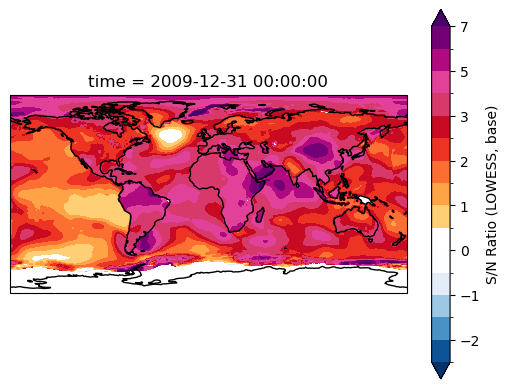

In [165]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
toe_metric_tree['best_tas'].sn_lowess_base.isel(time=-1).plot.contourf(
    ax=ax, levels=sn_levels_best, cmap=refined_cmap_best, extend='both')
ax.coastlines()

In [166]:
# sn_levels_cesm1, refined_cmap_cesm1 = generate_sn_colormap_and_levels_v3(
#     -4, 8, 1, 20, 2.5,# -1.5, 1
# )

sn_levels_cesm1, refined_cmap_cesm1 = generate_sn_colormap_and_levels_v3(
    -4, 11, 1, 26, 3,# -1.5, 1
)

Lower Levels: [-4 -3 -2 -1]
White Levels: [-1  0  1]
Orange Levels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
RdPu Levels: [11 14 17 20 23 26]
Total Levels: [-5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11 14 17 20 23 26 29]


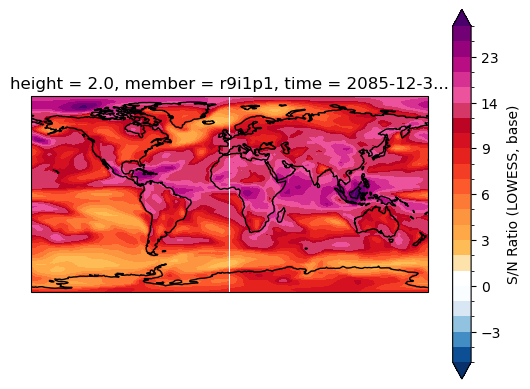

In [167]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
toe_metric_tree['access_ssp585_tas'].sn_lowess_base.isel(time=-1, member=-1).plot.contourf(
    ax=ax, levels=sn_levels_cesm1, cmap=refined_cmap_cesm1, extend='both')
ax.coastlines()

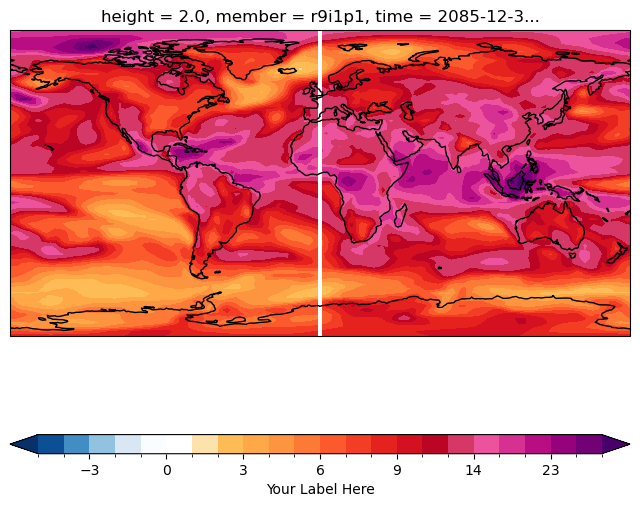

In [168]:
# Create figure and gridspec
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[20, 1], hspace=0.3)  # Adjust height ratio and spacing

# Create main plot
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())

# Plot data
contour = toe_metric_tree['access_ssp585_tas'].sn_lowess_base.isel(time=-1, member=-1).plot.contourf(
    ax=ax, levels=sn_levels_cesm1, cmap=refined_cmap_cesm1, extend='both', add_colorbar=False)

ax.coastlines()

# Create a dedicated axis for the colorbar
cax = fig.add_subplot(gs[1])

# Add colorbar
cbar = fig.colorbar(contour, cax=cax, orientation='horizontal')
cbar.set_label("Your Label Here")  # Optional label

plt.show()


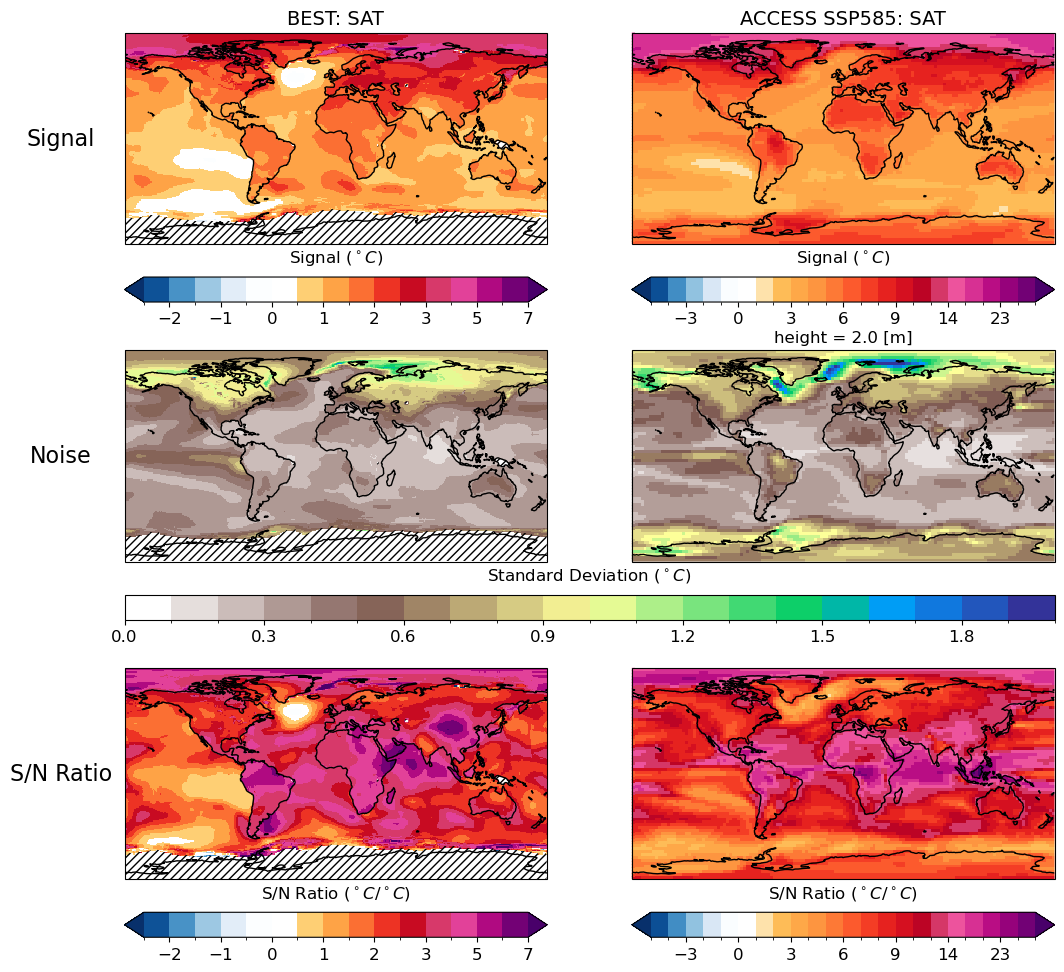

In [254]:
fontscale = 1.5
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 1, hspace=.1)

gs_kwargs = dict( height_ratios = [1, 0.1], hspace=.1)
gs_top =  gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0], **gs_kwargs) 
gs_mid =  gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1], **gs_kwargs)
gs_bottom =  gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[2], **gs_kwargs)

map_locations = range(0,2)
axes_top = [fig.add_subplot(gs_top[i], projection=ccrs.PlateCarree()) for i in map_locations]
axes_middle = [fig.add_subplot(gs_mid[i], projection=ccrs.PlateCarree()) for i in map_locations]
axes_bottom = [fig.add_subplot(gs_bottom[i], projection=ccrs.PlateCarree()) for i in map_locations]



cbars = []
for col, variable in enumerate(list(signal_tree)[:2]):
    signal_tf_da = signal_tree[variable].signal_lowess.isel(time=-1)
    ds_std = signal_tree[variable].noise_lowess.std(dim='time')
    sn_tf_da = toe_metric_tree[variable].sn_lowess_base.isel(time=-1)

    if 'member' in list(sn_tf_da.coords):
        signal_tf_da = signal_tf_da.median(dim='member')
        ds_std = ds_std.median(dim='member')
        sn_tf_da = sn_tf_da.median(dim='member')

        signal_levels = sn_levels_cesm1
        sn_levels = sn_levels_cesm1
        cmap = refined_cmap_cesm1
    else:
        signal_levels = sn_levels_best
        sn_levels = sn_levels_best
        cmap = refined_cmap_best

    
    plot_sig = signal_tf_da.plot(
        ax=axes_top[col], levels=signal_levels, add_colorbar=False, cmap=cmap, extend='both')
    
    plot_std = ds_std.plot(ax=axes_middle[col], add_colorbar=False, cmap=std_cmap, levels=std_levels)

    plot_sn = sn_tf_da.plot(
        ax=axes_bottom[col], add_colorbar=False, cmap=cmap, levels=sn_levels, extend='both')

    cbar1 = fig.colorbar(plot_sig, cax=fig.add_subplot(gs_top[-1, col]), orientation='horizontal')
    cbar2 = fig.colorbar(plot_sn, cax=fig.add_subplot(gs_bottom[-1, col]), orientation='horizontal')


    cbar_kwargs = dict(fontscale=fontscale, pad=10)
    if col == 0:
        cbar3 = fig.colorbar(plot_std, cax=fig.add_subplot(gs_mid[-1, :]), orientation='horizontal')
        plotting_utils.format_colobrar(cbar3, title='Standard Deviation '+ r'$(^\circ C)$', 
                                      **cbar_kwargs)
        # cbar3.set_label(r'Standard Deviation ('+ r'$^\circ C)')
    plotting_utils.format_colobrar(cbar1, title='Signal '+ r'$(^\circ C)$',
                                  **cbar_kwargs)
    plotting_utils.format_colobrar(cbar2, title='S/N Ratio '+ r'($^\circ C/^\circ C$)', 
                                  **cbar_kwargs)


    for ax in [axes_top[col], axes_middle[col], axes_bottom[col]]:
        if variable == 'best_tas':
            plotting_utils.hatch(
            ax, data_availability_tree[variable].to_dataset().to_array().squeeze(),
            **plotting_utils.not_stable_kwargs)
        ax.coastlines()

    if col == 0:
        axes_top[col].annotate('Signal', fontsize=16, xy=(-0.15, 0.5), ha='center', va='center', 
                           xycoords = 'axes fraction')
        axes_middle[col].annotate('Noise', fontsize=16, xy=(-0.15, 0.5), ha='center', va='center', 
                   xycoords = 'axes fraction')
        
        axes_bottom[col].annotate('S/N Ratio', fontsize=16, xy=(-0.15, 0.5), ha='center', va='center', 
                   xycoords = 'axes fraction')
    
    axes_bottom[col].set_title('')
    axes_top[col].set_title(NAME_MAPPING.get(variable, variable), fontsize=14)

<h3 style='color:green'> Pattern Correlations </h3>

In [170]:
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm
from matplotlib.colorbar import ColorbarBase

In [171]:
list(toe_tree)

['best_tas', 'access_ssp585_tas']

In [367]:
def create_pattern_corr_tree(toe_tree, tests):
    corr_restuls = {}
    for branch in toe_tree:
        print(f'{branch}, ')
        corr_restuls[branch] = toe_data_an.xarray_data_var_pattern_correlation_all_combs(
            (toe_tree[branch].to_dataset()[tests].median(dim='member')
            if 'member' in list(toe_tree[branch].to_dataset()[tests])
            else toe_tree[branch].to_dataset()[tests]
            )
        )
    pattern_corr_tree = xr.DataTree.from_dict(corr_restuls)
    return pattern_corr_tree

In [210]:
# tests = list(toe_tree.access_ssp585_tas)

In [415]:
relevent_metrics=  ['sn_lowess_base', 'ks', 'ttest', 'frac', 'perkins', 'hd'] #, 'sn_mean'
relevent_metrics_no_hype = np.array(
    [x for x in relevent_metrics if x not in ['ks', 'ttest']]
)
# tests = relevent_metrics

In [416]:
pattern_corr_tree = create_pattern_corr_tree(toe_tree, relevent_metrics)

best_tas, 
access_ssp585_tas, 


In [417]:
pattern_corr_unfamiliar_tree = create_pattern_corr_tree(toe_unfamiliar, relevent_metrics_no_hype)

best_tas, 
access_ssp585_tas, 


In [418]:
pattern_corr_unknown_tree = create_pattern_corr_tree(toe_unknown, relevent_metrics_no_hype)

best_tas, 
access_ssp585_tas, 


In [429]:
def plot_corr_heatmap(axes, pattern_corr_tree, relevant_metrics, title=False, heatmap_kwargs=None):
    """
    Plot correlation heatmaps for each branch in a provided data tree.

    Parameters:
    -----------
    axes : list of matplotlib.axes.Axes
        Axes objects for plotting each heatmap subplot.
    pattern_corr_tree : xr.DataTree
        DataTree containing correlation data for each branch.
    relevant_metrics : list of str
        Metrics to be selected and displayed in the heatmaps.
        Colormap for the heatmap.
    title : bool, optional, default=False
        Whether to display titles for each subplot based on branch names.

    Returns:
    --------
    None
    """
    if heatmap_kwargs is None: heatmap_kwargs = {}

    for i, branch in enumerate(pattern_corr_tree):
        ax = axes[i]
        heatmap_data = (pattern_corr_tree[branch]
                        .to_dataset()[relevant_metrics]
                        .sel(index=relevant_metrics)
                        .to_pandas().iloc[1:, :-1])

        heatmap = sns.heatmap(heatmap_data, annot=True, annot_kws={"size": 14},
                              fmt=".2f", vmin=0, vmax=1, ax=ax, cbar=False, **heatmap_kwargs)

        heatmap.set_xticklabels([toe_plots.METRIC_MAP.get(label.get_text(), label.get_text())
                                 for label in heatmap.get_xticklabels()], rotation=45, fontsize=14)

        heatmap.set_yticklabels([toe_plots.METRIC_MAP.get(label.get_text(), label.get_text())
                                 for label in heatmap.get_yticklabels()], rotation=0, fontsize=14)

        if title:
            ax.set_title(NAME_MAPPING.get(branch, branch), fontsize=18, pad=35)

        ax.set_xlabel("")
        ax.set_ylabel("")

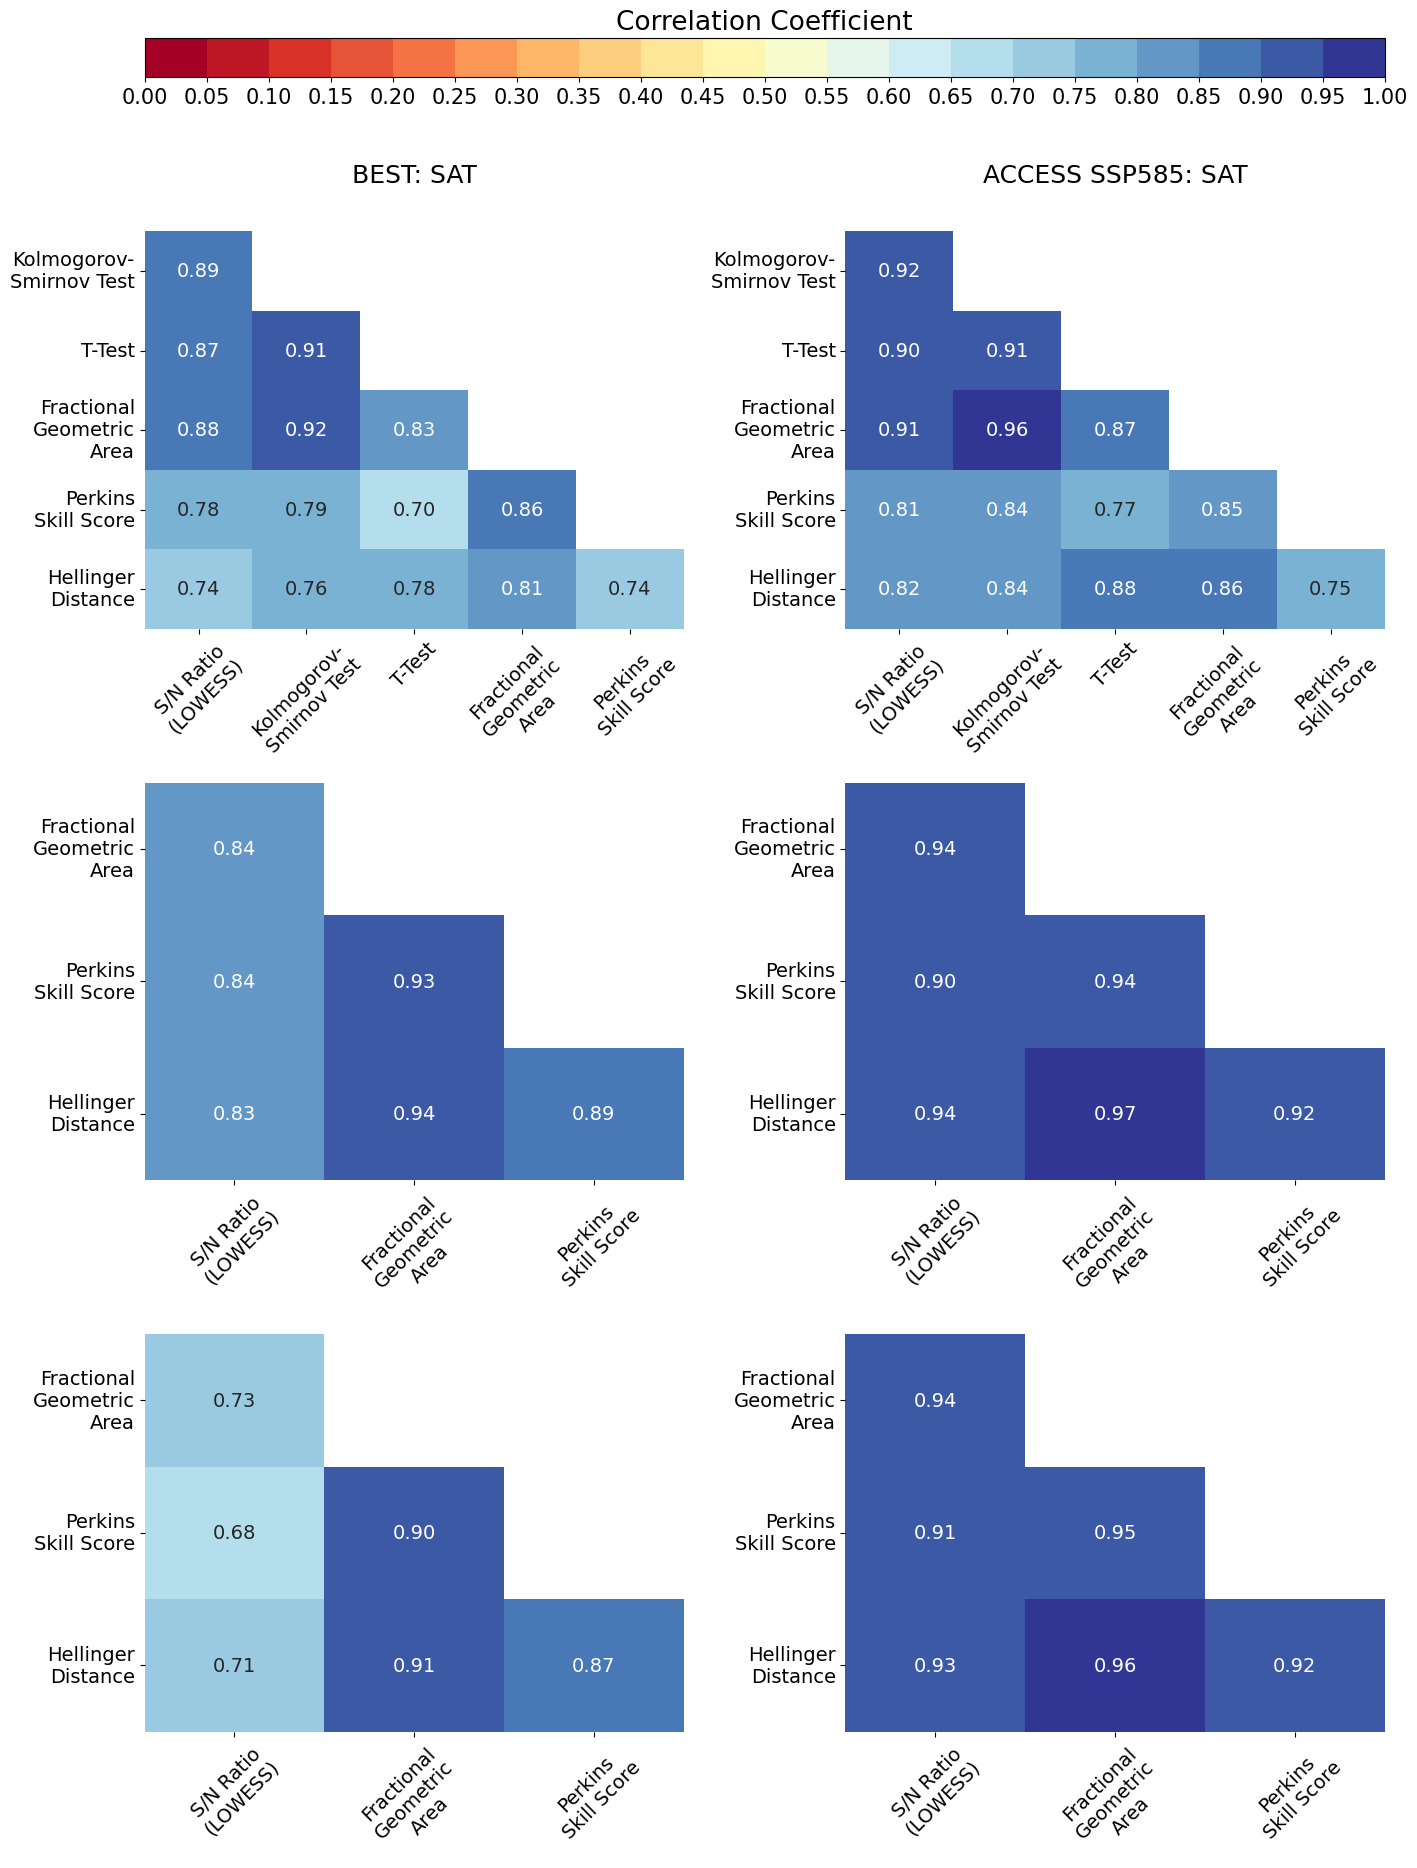

In [430]:
# Define the discrete color levels
levels = np.arange(0, 1.05, .05)
cmap = 'RdYlBu'#'coolwarm_r'  # Use the 'Blues' colormap
norm = BoundaryNorm(levels, ncolors=256)  # Create a normalization for the colorbar

# Set up the figure with gridspec for a shared colorbar
fig = plt.figure(figsize=(16, 22))
gs = gridspec.GridSpec(4, 2, height_ratios=[0.1] + [1]*3, hspace=0.5, wspace=0.3)
cbar_ax = fig.add_subplot(gs[0, :])  # Top row for the colorbar

# Add the colorbar
cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
cb.ax.set_title('Correlation Coefficient', fontsize=19)
cbar_ax.tick_params(labelsize=15)
cb.set_ticks(levels)
cb.ax.set_xticklabels([f'{level:.2f}' for level in levels])  # Set tick labels

# Create the 2x2 grid of heatmaps
axes = [fig.add_subplot(gs[i+2]) for i in range(2*3)]  # Bottom 2 rows

heatmap_kwargs = dict(norm=norm, cmap=cmap)
plot_corr_heatmap(axes[:2], pattern_corr_tree, relevent_metrics, title=True, heatmap_kwargs=heatmap_kwargs)
plot_corr_heatmap(axes[2:4], pattern_corr_unfamiliar_tree, relevent_metrics_no_hype,  heatmap_kwargs=heatmap_kwargs)
plot_corr_heatmap(axes[4:], pattern_corr_unknown_tree, relevent_metrics_no_hype, heatmap_kwargs=heatmap_kwargs)

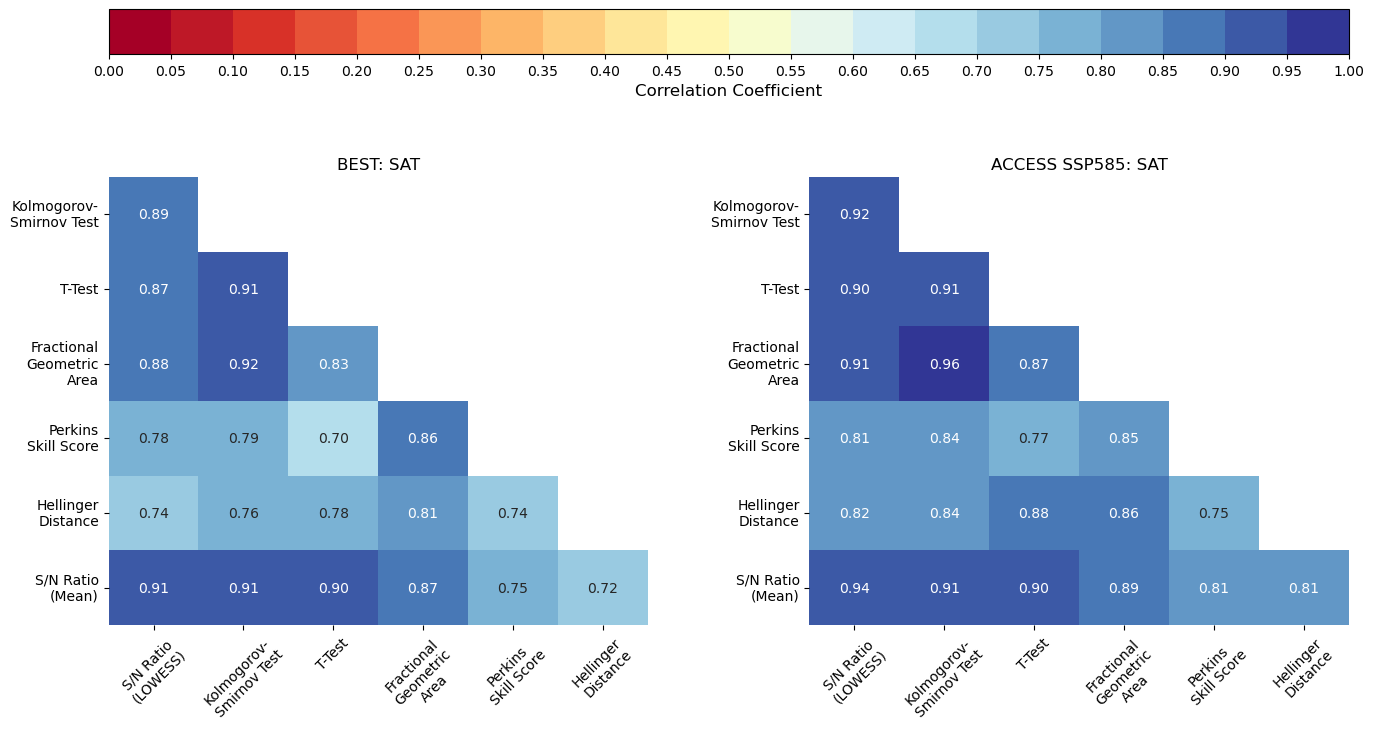

In [255]:
# Define the discrete color levels
levels = np.arange(0, 1.05, .05)
cmap = 'RdYlBu'#'coolwarm_r'  # Use the 'Blues' colormap
norm = BoundaryNorm(levels, ncolors=256)  # Create a normalization for the colorbar

# Set up the figure with gridspec for a shared colorbar
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[0.1, 1], hspace=0.5, wspace=0.3)
cbar_ax = fig.add_subplot(gs[0, :])  # Top row for the colorbar

# Add the colorbar
cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_label('Correlation Coefficient', fontsize=12)
cbar_ax.tick_params(labelsize=10)
cb.set_ticks(levels)
cb.ax.set_xticklabels([f'{level:.2f}' for level in levels])  # Set tick labels

# Create the 2x2 grid of heatmaps
axes = [fig.add_subplot(gs[1, i]) for i in range(2)]  # Bottom 2 rows

# Iterate through the keys and plot each heatmap in the grid
for i, branch in enumerate(pattern_corr_tree):
    
    ax = axes[i] 
    heatmap = sns.heatmap(
        pattern_corr_tree[branch].to_dataset()[relevent_metrics].sel(index=relevent_metrics)
        # .to_dataset()
        .to_pandas() .iloc[1:, :-1],
        annot=True, norm=norm, cmap=cmap, fmt='.2f', vmin=0, vmax=1, ax=ax, cbar=False)
    
    # Change the ticks to long names
    heatmap.set_xticklabels(
        [toe_plots.METRIC_MAP.get(text.get_text(), text.get_text()) for text in heatmap.get_xticklabels()]
    )
    heatmap.set_yticklabels(
        [toe_plots.METRIC_MAP.get(text.get_text(), text.get_text()) for text in heatmap.get_yticklabels()]
    )
    
    ax.set_title(NAME_MAPPING.get(branch, branch), fontsize=12)  # Add a title for each subplot
    ax.tick_params(axis='x', rotation=45, labelsize=10)  # Adjust x-axis labels
    ax.tick_params(axis='y', rotation=0, labelsize=10)  # Adjust y-axis labels
    ax.set_ylabel('')
    ax.set_xlabel('')

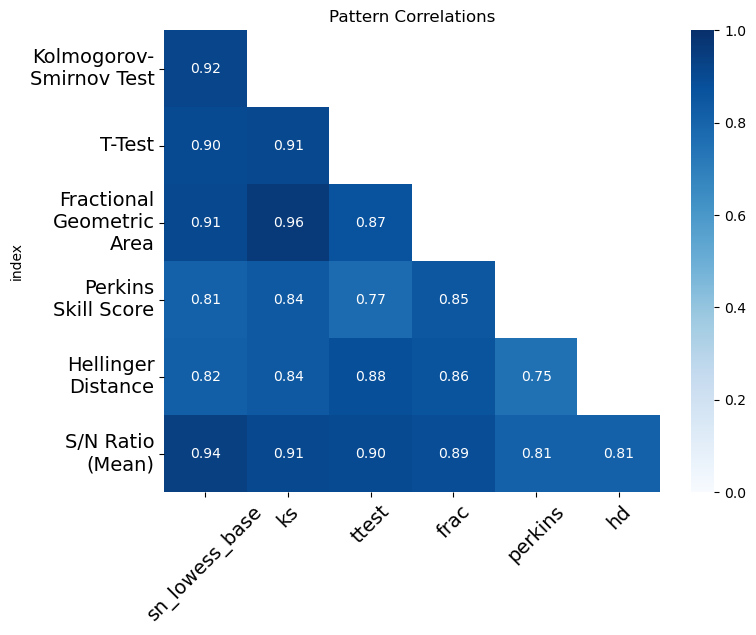

In [223]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    pattern_corr_tree['access_ssp585_tas'].to_dataset().to_pandas().iloc[1:, :-1], annot=True, cmap='Blues', fmt='.2f', vmin=0, vmax=1)

# Change the ticks to long names
heatmap.set_xticklabels(
    [NAME_MAPPING.get(text.get_text(), text.get_text()) for text in heatmap.get_xticklabels()]
)
heatmap.set_yticklabels([METRIC_MAP.get(text.get_text(), text.get_text()) for text in heatmap.get_yticklabels()])

plt.title('Pattern Correlations');
plt.xticks(rotation=45, fontsize=14);  # Rotate x-axis labels for better readability
plt.yticks(rotation=0, fontsize=14) ;  # Keep y-axis labels horizontal

<h3 style='color:green'> Cross Emergence </h3>

In [225]:
from scipy.stats import gaussian_kde

In [226]:
def generate_histogram(arr: np.ndarray, bins: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate a histogram from the input array.

    Parameters:
    arr (np.ndarray): The input array to generate the histogram from.
    bins (np.ndarray): The bin edges for the histogram.

    Returns:
    tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple containing the bin centers, the histogram values, and the histogram normalization factor.
    """
    # Remove NaN values from the input array
    vals = arr[np.isfinite(arr)]
    
    # Generate the histogram
    hist, bin_edges = np.histogram(vals, bins=bins, density=True)
    
    # Calculate the histogram normalization factor
    hist_norm = np.sum(hist)
    
    # Normalize the histogram
    hist = hist/hist_norm
    
    # Calculate the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    return bin_centers, hist, hist_norm


def generate_kde(arr: np.ndarray, hist_norm: float, bin_edges: np.ndarray) -> tuple[gaussian_kde, np.ndarray]:
    """
    Generate a kernel density estimate (KDE) from the input array.

    Parameters:
    arr (np.ndarray): The input array to generate the KDE from.
    hist_norm (float): The histogram normalization factor.
    bin_edges (np.ndarray): The bin edges for the histogram.

    Returns:
    tuple[gaussian_kde, np.ndarray]: A tuple containing the KDE generator and the normalized KDE values.
    """
    # Generate the KDE
    arr = arr[np.isfinite(arr)]
    kde_generator = gaussian_kde(arr)
    
    # Generate a grid of x values for the KDE
    x_grid = np.linspace(bin_edges[0], bin_edges[-1], 1000)
    
    # Evaluate the KDE at the x grid points
    kde_values = kde_generator(x_grid)
    
    # Normalize the KDE values
    kde_values_normalized = kde_values/hist_norm
    
    return kde_generator, kde_values_normalized

In [227]:
def plot_histogram_and_kde(bin_centers, histogram, histogram_norm, kde_generator, kde_values_normalized,
                   data, fig=None, ax=None, fontscale=1, *args, **kwargs):
    """
    Plots a histogram and kernel density estimate (KDE) for the input data.

    Parameters:
    bin_centers (array): The bin centers for the histogram.
    histogram (array): The histogram values.
    histogram_norm (float): The normalization factor for the histogram.
    kde_generator (function): The KDE generator function.
    kde_values_normalized (array): The normalized KDE values.
    data (DataFrame): The input data.

    Returns:
    fig, ax (tuple): The figure and axis objects for the plot.
    """
    if fig is None and ax is None:
        fig, ax = plt.subplots()

    # Plot the histogram with bars of width equal to the bin width
    # (accounting for floating point errors)
    ax.bar(bin_centers, histogram, width=np.unique(np.diff(bin_centers))[0].round(2), alpha=0.5)
    
    # Generate x values for the KDE plot
    x_grid = np.linspace(bin_centers[0], bin_centers[-1], 1000)
    
    # Plot the KDE
    ax.plot(x_grid, kde_values_normalized, label='KDE', color='black')
    
    # Set the axis labels and title
    ax.set_ylabel('Relative Frequency', fontsize=20*fontscale)
    ax.set_xlabel(kwargs.get('xlabel','Value'))
    ax.grid(True, alpha=0.3, color='grey', linestyle='--')

    # Calculate and plot the quantiles
    quantiles = {}
    percentiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    for q in percentiles:
        qval = np.nanpercentile(data, q*100).round(2).item()
        quantiles[q] = qval
        rf_val = kde_generator(qval).item()/ histogram_norm
        if q==0.5: style_dict = dict(linewidth=3, color='k')
        elif q==0.25 or q==0.75: style_dict = dict(linewidth=2, color='k', linestyle='--')
        elif q ==percentiles[0] or q==percentiles[-1]: style_dict = dict(linewidth=2, color='k', linestyle=':')

        # Plot the quantiles as vertical lines
        ax.plot([qval, qval], [0, rf_val], **style_dict)

        # round_number = lambda n: round(n - 0.05) if n % 10 != 0 else round(n)
        # ax.annotate(round_number(qval), xy=(qval+0.025*np.max(bincenters), 0),
        #             size=16, ha='center')

    # print(quantiles)
    
    return fig, ax

In [228]:
def calculate_and_plot_histogram(data, bins, fig=None, ax=None, fontscale=1, **kwargs):
    """
    Plots the distribution of values.

    Parameters:
    data (array-like): The data to plot.
    bins (array-like): The bins for the histogram.
    xlabel (str, optional): The label for the x-axis. Defaults to 'Distribution Overlap (%)'.

    Returns:
    fig, ax: The figure and axis objects for the plot.
    """
    bin_centers, histogram, histogram_norm = generate_histogram(data.flatten(), bins)
    kde_generator, kde_values_normalized = generate_kde(data.flatten(), histogram_norm, bin_centers)
    fig, ax = plot_histogram_and_kde(bin_centers, histogram, histogram_norm, kde_generator, kde_values_normalized, 
                             data, fig=fig, ax=ax, fontscale=fontscale)
    
    # ax.set_title(kwargs.get('title', ''), fontsize=25)
    # ax.set_xlabel(kwargs.get('xlabel', ''), fontsize=20)

    return fig, ax

In [511]:
def create_x_and_y_control_dict(good_xandy):

    ordered_vars = [
        'sn_lowess_base', 'ks', 'ttest', 'frac',
        'perkins', 'hd']
    
    # Custom sorting function
    def custom_sort(value):
        return ordered_vars.index(value)
    
    good_xandy_dict = {}
    for item in good_xandy:
        key, value = item.split('_at_')
        value = value.split('_emergence')[0]
        good_xandy_dict.setdefault(key, []).append(value)
    
    # Sort each list based on the custom order
    for key in good_xandy_dict: good_xandy_dict[key] = sorted(good_xandy_dict[key], key=custom_sort)
    
    good_xandy_dict = {key: good_xandy_dict[key] for key in ordered_vars if key in good_xandy_dict}
    
    return good_xandy_dict

In [512]:
METRIC_MAP_SHORT = {
 'sn_lowess_base': 'S/N',
 'ks': 'KS',
 'ttest': 'T-Test',
 'perkins': 'PSS',
 'frac': 'FGA',
 'hd': 'HD'
}

In [520]:

def create_x_at_y_median_iqr(x_at_y_emergence_tree, xaty_mets, banned_xandy=None):

    if banned_xandy is None: banned_xandy = {}
        
    # Extract valid keys from the dataset, excluding any that contain a banned term
    good_xandy = [metric for metric in xaty_mets
                  if not any(banned in metric for banned in banned_xandy)]
    
    
    good_xandy_dict = create_x_and_y_control_dict(good_xandy)
    
    order = np.concatenate(
        [[f'{key}_at_{value}_emergence' for value in good_xandy_dict[key]]for key in good_xandy_dict.keys()])
    
    x_and_y_av_dict = {}
    x_and_y_iqr_dict = {}
    
    for variable in x_at_y_emergence_tree:
        xand_ds = np.abs(x_at_y_emergence_tree[variable].to_dataset()[good_xandy])
        x_and_y_av_dict[variable] = xand_ds.median().to_pandas()
        x_and_y_iqr_dict[variable] = (xand_ds.quantile(0.75) - xand_ds.quantile(0.25)).to_pandas()
    
    x_and_y_av_df = pd.concat(x_and_y_av_dict, axis=1).loc[order]
    x_and_y_iqr_df = pd.concat(x_and_y_iqr_dict, axis=1).loc[order]
    
    return x_and_y_av_df, x_and_y_iqr_df

In [552]:
def create_percent_error_df(x_and_y_av_df, threshold_profile):
    percent_error_df = x_and_y_av_df.copy()
    # Create a boolean mask: True where row label (index) starts with "sn", False otherwise.
    sn_mask = percent_error_df.index.str.startswith('sn')
    overlap_mask = percent_error_df.index.str.startswith('frac') | percent_error_df.index.str.startswith('perkins')
    hd_mask = percent_error_df.index.str.startswith('hd')
    
    
    # Subtract 1 from rows starting with "sn"
    percent_error_df.loc[sn_mask] = 100*(percent_error_df.loc[sn_mask] - threshold_profile.sn_threshold)
    percent_error_df.loc[overlap_mask] = 100*(percent_error_df.loc[overlap_mask] - threshold_profile.overlap_threshold)/threshold_profile.overlap_threshold
    percent_error_df.loc[hd_mask] = 100*(percent_error_df.loc[hd_mask] - threshold_profile.hd_threshold)/threshold_profile.hd_threshold
    percent_error_df = percent_error_df.map(abs)

    return percent_error_df

In [553]:

# percent_error_df = x_and_y_av_df.copy()
# # Create a boolean mask: True where row label (index) starts with "sn", False otherwise.
# sn_mask = percent_error_df.index.str.startswith('sn')
# overlap_mask = percent_error_df.index.str.startswith('frac') | percent_error_df.index.str.startswith('perkins')
# hd_mask = percent_error_df.index.str.startswith('hd')


# # Subtract 1 from rows starting with "sn"
# percent_error_df.loc[sn_mask] = 100*(percent_error_df.loc[sn_mask] - 1)
# percent_error_df.loc[overlap_mask] = 100*(percent_error_df.loc[overlap_mask] - 63)/63
# percent_error_df.loc[hd_mask] = 100*(percent_error_df.loc[hd_mask] - 32)/32
# percent_error_df = percent_error_df.map(abs)

In [589]:
banned_xandy = {'sn_lowess_full', 'hawkins', 'sn_mean', 'sn_mean_roll'}
xaty_mets = list(x_at_y_emergence_tree.best_tas)

In [590]:
x_and_y_av_df, x_and_y_iqr_df = create_x_at_y_median_iqr(
    x_at_y_emergence_tree, xaty_mets, banned_xandy)

In [593]:
percent_error_df = create_percent_error_df(x_and_y_av_df, toe_const.ThresholdProfileUnusual)

In [594]:
percent_error_df.head()

best_tas  access_ssp585_tas
sn_lowess_base_at_ks_emergence        1.203981           2.661373
sn_lowess_base_at_ttest_emergence    15.438739          17.907340
sn_lowess_base_at_frac_emergence      3.180096           4.568788
sn_lowess_base_at_perkins_emergence   4.217434          12.219689
sn_lowess_base_at_hd_emergence       27.739693          25.081218

In [595]:
# This is for the purpoe os the heatmap
# Signal to noise is to 2 dp, overlap is to 2dp and iqr in brackets
# e.g. 1.01 (0.3)
av_map_to_string = lambda val: f'{val:.2f}'if val < 10 else f'{int(np.round(val, 0))}'
iqr_map_to_string = lambda val: f' ({val:.1f})'if val < 10 else f' ({val:0.1f})'

x_and_y_formatted_df = x_and_y_av_df.map(av_map_to_string)+ x_and_y_iqr_df.map(iqr_map_to_string)
x_and_y_formatted_df.tail()

best_tas access_ssp585_tas
hd_at_sn_lowess_base_emergence  41 (6.6)          41 (5.9)
hd_at_ks_emergence              40 (7.2)          41 (6.5)
hd_at_ttest_emergence           37 (6.6)          36 (5.7)
hd_at_frac_emergence            41 (5.4)          41 (5.7)
hd_at_perkins_emergence         42 (8.2)          43 (9.4)

In [596]:
ylabels = []
main_type = percent_error_df.index.values[0].split('_at')[0]
for num, xandy_type in enumerate(percent_error_df.index.values):
    current_type = xandy_type.split('_at')[0]
    secondary_type = xandy_type.split('at_')[-1].split('_emergence')[0]

    if current_type != main_type or num == 0:
        main_type = current_type
        main_type_str = METRIC_MAP_SHORT.get(current_type, current_type).replace('\n', '')
        start_tag = f'{main_type_str} at : '
    else: start_tag = ''

    ylabel = start_tag + METRIC_MAP_SHORT.get(secondary_type, secondary_type).replace('\n', '')
    ylabels.append(ylabel)

In [597]:
percent_error_df.head()

best_tas  access_ssp585_tas
sn_lowess_base_at_ks_emergence        1.203981           2.661373
sn_lowess_base_at_ttest_emergence    15.438739          17.907340
sn_lowess_base_at_frac_emergence      3.180096           4.568788
sn_lowess_base_at_perkins_emergence   4.217434          12.219689
sn_lowess_base_at_hd_emergence       27.739693          25.081218

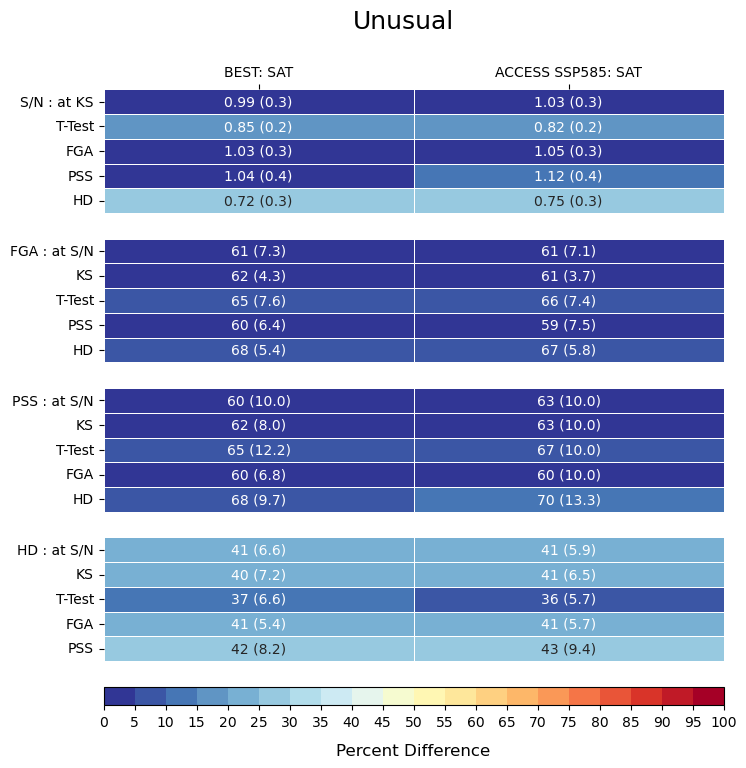

In [599]:
# Define the discrete color levels
levels = np.arange(0, 105, 5)
cmap = 'RdYlBu_r'
norm = BoundaryNorm(levels, ncolors=256)

# Set up the figure with gridspec for a shared colorbar
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(5, 1, height_ratios=[1]*4 + [0.15], hspace=0.25)  # Move colorbar to the bottom
cbar_ax = fig.add_subplot(gs[-1, :])  # Bottom row for the colorbar

fig.suptitle('Unusual', fontsize=18)

# Add the colorbar
cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_label('Percent Difference', fontsize=12, labelpad=10)
cb.ax.xaxis.set_label_position('bottom')  # Move label to the bottom
cb.set_ticks(levels)
cb.ax.set_xticklabels(levels)

for num, start_metric in enumerate(list(good_xandy_dict)):
    mask = percent_error_df.index.str.startswith(start_metric)
    ax = fig.add_subplot(gs[num])

    heatmap = sns.heatmap(percent_error_df.loc[mask],
                          annot=x_and_y_formatted_df.loc[mask],
                          ax=ax, fmt='',
                          linewidths=0.5, vmin=0, vmax=100, norm=norm,
                          cmap=cmap, cbar=False)

    ylabels = []
    for num2, xandy_type in enumerate(heatmap.get_yticklabels()):
        label = ''
        if num2 == 0:
            current_type = xandy_type.get_text().split('_at')[0]
            label += METRIC_MAP_SHORT.get(current_type, current_type).replace('\n', '')
            label += ' : at '
        secondary_type = xandy_type.get_text().split('at_')[-1].split('_emergence')[0]
        label += METRIC_MAP_SHORT.get(secondary_type, secondary_type).replace('\n', '')
        ylabels.append(label)
    
    heatmap.set_yticklabels(ylabels)

    # Move x-axis labels to the top for all heatmaps
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    if num == 0:
        heatmap.set_xticklabels(
            [toe_plots.NAME_MAPPING.get(text.get_text(), text.get_text())
             for text in heatmap.get_xticklabels()]
        )
    else: heatmap.set_xticklabels(['', '']); heatmap.set_xticks([])

<h1 style='color:yellow'> Different Base Periods </h1>

<h2 style='color:cyan'> Opening Data </h2>

In [196]:
# mulit_base_period_dict = {
#     'best_tas': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/best_tas_multi_base_period.zarr',
#     'access_ssp585_tas': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_tas_multi_base_period.zarr'}

In [197]:
# mulit_base_period_tree = open_files_datatree(
#     mulit_base_period_dict, 'metric', engine='zarr', chunks='auto').persist()
# wait(mulit_base_period_tree)

In [198]:
# base_period_pattern =  re.compile(r"^best_tas_\(\d{4}_\d{4}\)(?!_\d+p0x\d+p0$)")
# base_period_files = [s for s in all_files if base_period_pattern.search(s)]
# base_period_files

In [199]:
# base_period_file_manager = FileNameManager(base_period_files, constants.TOE_SAVE_DIR)
# base_period_file_manager

In [200]:
# base_period_dict = base_period_file_manager.generate_dict_no_strip('toe_metrics.zarr')
# base_period_dict

In [201]:
# %%time
# best_base_period_tree = open_files_datatree(
#     base_period_dict, 'metrics', engine='zarr', use_cftime=True).persist()
# wait(best_base_period_tree);

In [202]:
metric_base_period_best_ds = xr.open_dataset(
    '/g/data/w40/ab2313/time_of_emergence/toe_metrics/'
    'best_tas_multi_base_period.zarr',
    engine='zarr'
).chunk(CHUNK_DICT['best_tas']).persist()
wait(metric_base_period_best_ds);

In [203]:
metric_base_period_cesm1_ds = xr.open_dataset(
    '/g/data/w40/ab2313/time_of_emergence/toe_metrics/'
    'access_ssp585_tas_multi_base_period.zarr',
    engine='zarr'
).chunk(CHUNK_DICT['cesm1']).persist()
wait(metric_base_period_cesm1_ds);

FileNotFoundError: No such file or directory: '/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_tas_multi_base_period.zarr'

In [ ]:
metric_base_period_best_ds

<h2 style='color:cyan'> Calculations </h2>

In [ ]:
toe_base_period_best_ds = get_permanent_exceedance_multi_metrics(
    metric_base_period_best_ds, toe_const.ThresholdProfileUnusual).persist()
wait(metric_base_period_best_ds);

In [ ]:
toe_base_period_cesm1_ds = get_permanent_exceedance_multi_metrics(
    metric_base_period_cesm1_ds, toe_const.ThresholdProfileUnusual).persist()
wait(toe_base_period_cesm1_ds);

In [ ]:
toe_unfamiliar_base_period_cesm1_ds = get_permanent_exceedance_multi_metrics(
    metric_base_period_cesm1_ds[['sn', 'frac']], toe_const.ThresholdProfileUnfamiliar).persist()
wait(toe_unfamiliar_base_period_cesm1_ds);

In [ ]:
toe_unknown_base_period_cesm1_ds = get_permanent_exceedance_multi_metrics(
    metric_base_period_cesm1_ds[['sn', 'frac']], toe_const.ThresholdProfileUnknown).persist()
wait(toe_unknown_base_period_cesm1_ds);

In [ ]:
def get_toe_delay(ds: xr.Dataset) -> xr.DataArray:
    """
    Calculate the delay in Time of Emergence (ToE) relative to the center of each base period.

    Parameters:
    ds (xr.Dataset): An xarray Dataset containing a coordinate 'base_period' 
                     with values formatted as strings (e.g., '1990_2000').

    Returns:
    xr.DataArray: A DataArray representing the delay in ToE for each base period.
    """
    time_until_emergence_stor = []
    
    for base_period in list(ds.base_period.values):
        # The start of the base period + half the length of the base period
        base_period_center = int(base_period.split('_')[0]) + 15
    
        toe_delay_ds = ds.sel(base_period=base_period) - base_period_center
        
        time_until_emergence_stor.append(toe_delay_ds)
    
    time_until_emergence_ds = xr.concat(time_until_emergence_stor, dim='base_period')

    return time_until_emergence_ds


In [ ]:
time_until_emergence_cesm1_ds = get_toe_delay(toe_base_period_cesm1_ds.median(dim='member'))
time_until_emergence_unfamiliar_cesm1_ds = get_toe_delay(toe_unfamiliar_base_period_cesm1_ds.median(dim='member'))
time_until_emergence_unknown_cesm1_ds = get_toe_delay(toe_unknown_base_period_cesm1_ds.median(dim='member'))

In [ ]:
time_until_emergence_cesm1_stats = time_until_emergence_cesm1_ds.quantile(
    [0.05, 0.5, 0.95], dim=['lat', 'lon']).compute()

In [ ]:
time_until_emergence_unfamiliar_cesm1_stats = time_until_emergence_unfamiliar_cesm1_ds.quantile(
    [0.05, 0.5, 0.95], dim=['lat', 'lon']).compute()

time_until_emergence_unknown_cesm1_stats = time_until_emergence_unknown_cesm1_ds.quantile(
    [0.05, 0.5, 0.95], dim=['lat', 'lon']).compute()

In [ ]:
time_until_emergence_best_ds = get_toe_delay(toe_base_period_best_ds)
time_until_emergence_best_ds = time_until_emergence_best_ds.isel(base_period=slice(None, -5))

In [ ]:
time_until_emergence_best_stats_ds = time_until_emergence_best_ds.quantile(
    [0.05, 0.5, 0.95], dim=['lat', 'lon']).compute().sortby('base_period')

In [ ]:
time_until_emergence_best_stats_ds.base_period.values

In [ ]:
def percent_not_emerging(ds, dim):
    percent_ds = 100*ds.count(dim=dim)/xr.where(ds, 1, 1).count(dim=dim)
    return percent_ds

In [ ]:
percent_cesm1 = percent_not_emerging(toe_base_period_cesm1_ds, dim=['member', 'lat', 'lon']).compute()
percent_cesm1_unknown = percent_not_emerging(toe_unknown_base_period_cesm1_ds, dim=['member', 'lat', 'lon']).compute()
percent_cesm1_unfamiliar = percent_not_emerging(toe_unfamiliar_base_period_cesm1_ds, dim=['member', 'lat', 'lon']).compute()

In [ ]:
toe_base_period_best_ds.sortby('base_period').sn.isel(base_period=[0, 10, -10, -1]).plot(col='base_period', col_wrap=2)

<h2 style='color:cyan'> Plots </h2>

In [ ]:
def plot_time_until_emergence(
    time_until_emergence_stats_ds: xr.Dataset,
    fig=None, axes=None, 
    add_legend=True, annotate=True,
    ylim:float=150, ylabel='Years Until Emergence',
):
    """
    Plots the time until emergence using different statistical metrics.
    
    Parameters:
    time_until_emergence_stats_ds : xarray.Dataset
        Dataset containing time until emergence statistics.
    fig : matplotlib.figure.Figure, optional
        Figure object to use for plotting. If None, a new figure is created.
    axes : list of matplotlib.axes.Axes, optional
        List of axes to use for plotting. If None, new axes are created.
    
    Returns:
    fig : matplotlib.figure.Figure
        The figure containing the plot.
    axes : list of matplotlib.axes.Axes
        The list of axes used in the plot.
    """


    import matplotlib.lines as mlines
    import matplotlib.patches as mpatches

    toe_metrics = list(time_until_emergence_stats_ds)
    base_period_centres = np.array([
        int(x.split('_')[0]) + 15 for x in time_until_emergence_stats_ds.base_period.values
    ])
    
    if fig is None or axes is None:
        fig = plt.figure(figsize=(6, 2*len(toe_metrics)))
        gs = gridspec.GridSpec(len(toe_metrics), 1, hspace=0.1)
        axes = [fig.add_subplot(gs[i]) for i in range(len(toe_metrics))]
    
    for num, metric in enumerate(toe_metrics):
        ax = axes[num]
        ax.grid(True, linestyle='--', color='grey', alpha=0.5)

        color = toe_plots.TEST_STYLES[metric]['color']
        label = toe_plots.METRIC_MAP[metric]

        ax.fill_between(
            base_period_centres,
            time_until_emergence_stats_ds[metric].isel(quantile=0).values,
            time_until_emergence_stats_ds[metric].isel(quantile=2).values,
            color=color, alpha=.75
        )
        
        ax.plot(
            base_period_centres, 
            time_until_emergence_stats_ds[metric].sel(quantile=0.5).values,
            color='k', label=label
        )
        
        if annotate: ax.annotate(
            label, xy=(0.5, 0.7), xycoords='axes fraction', ha='center', va='center',
            color='k', fontsize=12
        )
        
        ax.set_ylim(0, ylim)
        ax.set_title('')
        ax.set_xlim(np.take(base_period_centres, [0, -1]))

        if num == 1:
            ax.set_xticklabels('')
            ax.set_xlabel('')   
        if num == 0:
            # ax.xaxis.set_label_position('top')
            ax.xaxis.tick_top()

    if ylabel: axes[1].set_ylabel(ylabel, fontsize=12)
    
    for ax in [axes[-1]]:#np.take(axes, [-1, 0]):
        ax.set_xlabel('Base Period Central Year (length=30 years)', fontsize=10)

    if add_legend:
        # Create custom legend handles
        black_line = mlines.Line2D([], [], color='k', label='Median')
        shaded_area = mpatches.Patch(color='grey', alpha=0.5, label='Range')
        
        # Place the legend outside the plot
        axes[0].legend(handles=[black_line, shaded_area], loc='upper right')
    
    return fig, axes

In [ ]:
plt.figure(figsize=(6, 2))
plt.plot(percent_cesm1.sn.values)
plt.plot(percent_cesm1_unknown.sn.values)
plt.plot(percent_cesm1_unfamiliar.sn.values)

In [ ]:
def percent_emerged_plot_adder(ds, metrics, axes):
    axes_twinx = []
    for metric, ax in zip(metrics, axes):
        ax_twinx = ax.twinx()
        ax_twinx.plot(ax.lines[0].get_xdata(), ds[metric].values, linewidth=1, color='purple')
        ax_twinx.set_ylim(0, 102)
        axes_twinx.append(ax_twinx)
        # Set tick labels, y-ticks, and right spine to purple
        ax_twinx.tick_params(axis='y', colors='purple')
        ax_twinx.yaxis.label.set_color('purple')
        ax_twinx.spines['right'].set_color('purple')
    return axes_twinx

In [ ]:
# Create figure and gridspec (multiple rows, 1 column)
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(3, 3, hspace=0.1, wspace=0.25)
axes_left = [fig.add_subplot(gs[i, 0]) for i in range(3)]
axes_middle = [fig.add_subplot(gs[i, 1]) for i in range(2)]
axes_right = [fig.add_subplot(gs[i, 2]) for i in range(2)]

plot_time_until_emergence(time_until_emergence_cesm1_stats[['sn', 'frac', 'ks']], fig=fig, axes=axes_left, annotate=False, ylim=150);

plot_kwargs = dict(ylim=150, ylabel=None, add_legend=False, annotate=False)
plot_time_until_emergence(time_until_emergence_unfamiliar_cesm1_stats[['sn', 'frac']], fig=fig, axes=axes_middle, **plot_kwargs);
plot_time_until_emergence(time_until_emergence_unknown_cesm1_stats[['sn', 'frac']], fig=fig, axes=axes_right, **plot_kwargs);


percent_emerged_plot_adder(percent_cesm1, ['sn', 'frac', 'ks'], axes_left);
percent_emerged_plot_adder(percent_cesm1_unfamiliar, ['sn', 'frac'], axes_middle);
axes_twinx_right = percent_emerged_plot_adder(percent_cesm1_unknown, ['sn', 'frac'], axes_right);

axes_twinx_right[1].set_ylabel('Percent with No Emergence', fontsize=12)


titles = ['Unusual', 'Unfamiliar', 'Unknown']
for title, ax in zip(titles, [axes_left[0], axes_middle[0], axes_right[0]]): ax.set_title(title, fontsize=14)

for label, ax in zip(['sn', 'frac', 'ks'],axes_left):
    ax.set_ylabel(toe_plots.METRIC_MAP.get(label, label), fontsize=14)

In [ ]:
plot_time_until_emergence(time_until_emergence_cesm1_stats, ylim=100);

In [ ]:
plot_time_until_emergence(time_until_emergence_best_stats_ds);

<h2 style='color:cyan'> Opening Data </h2>

<h1 style='color:yellow'> Different Resolution</h1>

<h2 style='color:cyan'> Opening Data </h2>

In [8]:
def extract_resolution(s):
    """Extracts numeric resolution as an integer tuple (smaller first)."""
    match = re.search(r"_(\d+)p0x(\d+)p0", s)
    if match:
        return tuple(map(int, match.groups()))  # Convert '4p0x4p0' -> (4, 4)
    return (float('inf'), float('inf'))  # Pl

In [9]:
# Files that contain different resolutions for best
resultion_pattern = re.compile(r"_\d+p0x\d+p0")  # Matches "_Xp0xXp0" where X is any number
resolution_files = [s for s in all_files if resultion_pattern.search(s)]
resolution_files = sorted(resolution_files, key=extract_resolution)
resolution_files = np.insert(resolution_files, 0, 'best_tas_(1920_1950)')
resolution_files

array(['best_tas_(1920_1950)', 'best_tas_(1920_1950)_2p0x2p0',
       'best_tas_(1920_1950)_4p0x4p0', 'best_tas_(1920_1950)_8p0x8p0',
       'best_tas_(1920_1950)_16p0x16p0', 'best_tas_(1920_1950)_32p0x32p0'],
      dtype='<U30')

In [16]:
resolution_file_manager = FileNameManager(base_period_files, constants.TOE_SAVE_DIR)
resolution_file_manager

/g/data/w40/ab2313/time_of_emergence/toe_metrics
----
['best_tas_(1880_1910)', 'best_tas_(1890_1920)', 'best_tas_(1900_1930)', 'best_tas_(1910_1940)', 'best_tas_(1920_1950)', 'best_tas_(1930_1960)', 'best_tas_(1940_1970)']

In [18]:
resolution_dict = resolution_file_manager.generate_dict_no_strip('toe_metrics.zarr')

In [22]:
%%time
best_resolution_tree = open_files_datatree(
    resolution_dict, 'metrics', engine='zarr', use_cftime=True).persist()
wait(best_resolution_tree);

CPU times: user 335 ms, sys: 46.5 ms, total: 381 ms
Wall time: 362 ms


<h2 style='color:cyan'> Calculations </h2>

In [48]:
toe_best_base_period_tree = best_base_period_tree.map_over_datasets(
    get_permanent_exceedance_multi_metrics, toe_const.ThresholdProfileUnusual, 'INFO').compute()

 - test='frac' - threshold=62 - <ufunc 'less'>
 - test='hd' - threshold=33 - <ufunc 'greater_equal'>
 - test='ks' - threshold=0.01 - <ufunc 'less'>
 - test='perkins' - threshold=62 - <ufunc 'less'>
 - test='sn_hawkins_base' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_hawkins_full' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_lowess_base' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_lowess_full' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_mean' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_mean_roll' - threshold=1 - <ufunc 'greater_equal'>
 - test='ttest' - threshold=0.01 - <ufunc 'less'>
 - test='frac' - threshold=62 - <ufunc 'less'>
 - test='hd' - threshold=33 - <ufunc 'greater_equal'>
 - test='ks' - threshold=0.01 - <ufunc 'less'>
 - test='perkins' - threshold=62 - <ufunc 'less'>
 - test='sn_hawkins_base' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_hawkins_full' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_lowess_base' - threshold=1 

In [53]:
toe_best_resolution_tree = best_resolution_tree.map_over_datasets(
    get_permanent_exceedance_multi_metrics, toe_const.ThresholdProfileUnusual, 'ERROR').compute()

In [55]:
list(toe_metric_tree.best_tas)

['frac',
 'hd',
 'ks',
 'perkins',
 'sn_hawkins_base',
 'sn_hawkins_full',
 'sn_lowess_base',
 'sn_lowess_full',
 'sn_mean',
 'sn_mean_roll',
 'ttest']

1974.0 1906.0 2009.0
1971.0 1916.0 2009.0
1974.0 1927.0 2009.0
1981.0 1936.0 2009.0
1987.0 1946.0 2009.0
1990.0 1955.0 2009.0
1992.0 1963.0 2009.0


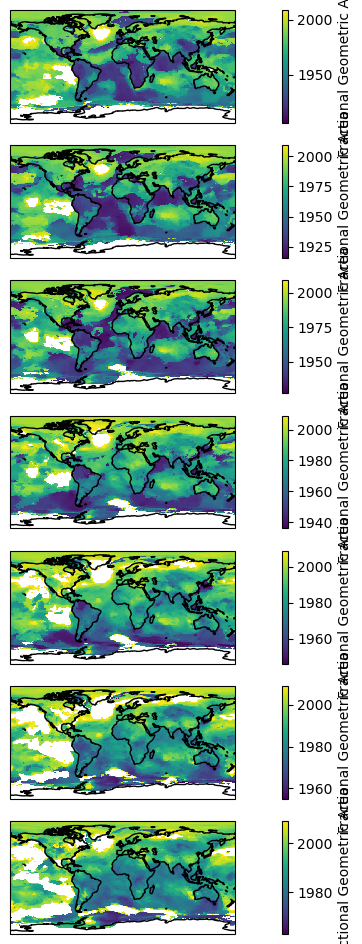

In [65]:
fig = plt.figure(figsize=(12, 12))
axes = [fig.add_subplot(len(toe_best_resolution_tree), 1, i+1, projection=ccrs.PlateCarree()) for i in range(len(toe_best_resolution_tree))]
for num, branch in enumerate(list(toe_best_resolution_tree)):
    ax = axes[num]
    res_da = toe_best_resolution_tree[branch].to_dataset()['frac']
    res_da.plot(ax=ax)
    ax.coastlines()
    print(res_da.median().values.item(), res_da.min().values, res_da.max().values)